# Lietuvos oro duomen≈≥ analizƒós sistema

≈†is notebook demonstravo visas sistemos galimybes naudojant Lietuvos hidrometeorologijos tarnybos API (meteo.lt).

## Turinys
1. [Sistemos paruo≈°imas](#sistemos-paruo≈°imas)
2. [Duomen≈≥ gavimas i≈° API](#duomen≈≥-gavimas-i≈°-api)
3. [Duomen≈≥ analizƒó](#duomen≈≥-analizƒó)
4. [Vizualizacijos](#vizualizacijos)
5. [Temperat≈´ros interpoliacija](#temperat≈´ros-interpoliacija)
6. [Miest≈≥ palyginimas](#miest≈≥-palyginimas)
7. [I≈°vados](#i≈°vados)

## Sistemos galimybƒós
- **API integracija** - meteo.lt duomen≈≥ nuskaitymas
- **Duomen≈≥ analizƒó** - statistikos ir tendencij≈≥ analizƒó
- **Vizualizacijos** - interaktyv≈´s grafikai ir dashboard
- **Interpoliacija** - temperat≈´ros duomen≈≥ tankumo didinimas iki 5 min
- **Miest≈≥ palyginimas** - keli≈≥ miest≈≥ oro sƒÖlyg≈≥ analizƒó
- **Eksportavimas** - rezultat≈≥ i≈°saugojimas CSV/JSON formatais

## Palaikomi miestai
Vilnius, Kaunas, Klaipƒóda, ≈†iauliai, Panevƒó≈æys ir kiti Lietuvos miestai.

**Pradƒókime analizƒô!**

## 1. Aplinkos paruo≈°imas

Importuojame reikalingas bibliotekas ir nustatome parametrus.

In [149]:
# Importuoti reikalingas bibliotekas
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime, timedelta
import json
import os

# Pridƒóti src aplanko keliƒÖ
sys.path.append('../src')
sys.path.append('.')

warnings.filterwarnings('ignore')

# Spausdinti sistemos informacijƒÖ
print("Visi moduliai sƒókmingai importuoti!")
print("Sistemos oro duomen≈≥ analizƒós moduliai paruo≈°ti")
print()
print("Sistema paruo≈°ta analizei!")
print(f"Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python versija: {sys.version}")
print(f"Pandas versija: {pd.__version__}")
print(f"Matplotlib versija: {plt.matplotlib.__version__}")
print(f"Seaborn versija: {sns.__version__}")

Visi moduliai sƒókmingai importuoti!
Sistemos oro duomen≈≥ analizƒós moduliai paruo≈°ti

Sistema paruo≈°ta analizei!
Data: 2025-08-08 01:49:37
Python versija: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Pandas versija: 2.1.4
Matplotlib versija: 3.8.2
Seaborn versija: 0.13.2


In [150]:
# Importuoti oro analizƒós modulius su perkrovimu
import sys
import os
import importlib

sys.path.append(os.path.join('..', 'src'))

try:
    # Perkrauti modulius jei jie jau buvo importuoti
    if 'weather_api' in sys.modules:
        importlib.reload(sys.modules['weather_api'])
    if 'data_analysis' in sys.modules:
        importlib.reload(sys.modules['data_analysis'])
    if 'visualization' in sys.modules:
        importlib.reload(sys.modules['visualization'])
    if 'interpolation' in sys.modules:
        importlib.reload(sys.modules['interpolation'])
    
    # Importuoti i≈° src aplanko
    from weather_api import WeatherAPI
    from data_analysis import WeatherAnalyzer
    from visualization import WeatherVisualizer
    from interpolation import TemperatureInterpolator
    
    print("M≈´s≈≥ oro analizƒós moduliai sƒókmingai importuoti!")
    
    # Rodyti galimus miestus
    CITY_CODES = {
        'vilnius': 'vilnius',
        'kaunas': 'kaunas', 
        'klaipeda': 'klaipeda',
        'siauliai': 'siauliai',
        'panevezys': 'panevezys'
    }
    
    print(f"Galimi miestai: {list(CITY_CODES.keys())}")
    
    # Patikrinti ar WeatherAPI turi reikalingus metodus
    test_api = WeatherAPI('vilnius')
    available_methods = [method for method in dir(test_api) if not method.startswith('_')]
    print(f"Prieinami API metodai: {available_methods}")
    
except ImportError as e:
    print(f"Importavimo klaida: {e}")
    print("Patikrinkite ar src moduliai yra teisingoje vietoje")

M≈´s≈≥ oro analizƒós moduliai sƒókmingai importuoti!
Galimi miestai: ['vilnius', 'kaunas', 'klaipeda', 'siauliai', 'panevezys']
Prieinami API metodai: ['base_url', 'city_codes', 'get_current_weather', 'get_forecast_data', 'get_historical_data', 'lithuania_tz', 'location_code', 'predict_weekend_rain', 'session']


## 2. Duomen≈≥ nuskaitymas

Nuskaitome istorinius ir prognozƒós duomenis i≈° meteo.lt API.

In [151]:
# Inicializuoti Weather API
try:
    weather_api = WeatherAPI("vilnius")
    print("Weather API inicializuotas miestui: vilnius")
    print(f"API URL: {weather_api.base_url}")
    print(f"Laiko zona: {weather_api.lithuania_tz}")
    
    # Inicializuoti visualization modulƒØ
    visualizer = WeatherVisualizer()
    print("Vizualizacijos modulis inicializuotas")
    
    # Inicializuoti interpoliacijos modulƒØ
    interpolator = TemperatureInterpolator()
    print("Interpoliacijos modulis inicializuotas")
    
except Exception as e:
    print(f"API inicializacijos klaida: {e}")
    print("Programa bandys tƒôsti su daliniais moduliais...")

Weather API inicializuotas miestui: vilnius
API URL: https://api.meteo.lt/v1
Laiko zona: Europe/Vilnius
Vizualizacijos modulis inicializuotas
Interpoliacijos modulis inicializuotas


In [152]:
# Nuskaitome realius duomenis TIK i≈° API (be mock duomen≈≥)
print("NAUDOJAMI TIK REAL≈™S API DUOMENYS")
print("=" * 50)

# Gauti dabartinius oro duomenis
print("1. Nuskaitomi dabartiniai oro duomenys...")
current_weather = weather_api.get_current_weather()

if current_weather:
    print("DABARTINIAI ORO DUOMENYS:")
    print(f"‚Ä¢ Miestas: {current_weather['place']['name']}")
    print(f"‚Ä¢ Temperat≈´ra: {current_weather.get('airTemperature', 'N/A')}¬∞C")
    print(f"‚Ä¢ Jauƒçiama temperat≈´ra: {current_weather.get('feelsLikeTemperature', 'N/A')}¬∞C")
    print(f"‚Ä¢ Drƒógmƒó: {current_weather.get('relativeHumidity', 'N/A')}%")
    print(f"‚Ä¢ Vƒójo greitis: {current_weather.get('windSpeed', 'N/A')} m/s")
    print(f"‚Ä¢ Slƒógimas: {current_weather.get('seaLevelPressure', 'N/A')} hPa")
    print(f"‚Ä¢ Krituliai: {current_weather.get('totalPrecipitation', 'N/A')} mm")
    print(f"‚Ä¢ Oro sƒÖlygos: {current_weather.get('conditionCode', 'N/A')}")
    print(f"‚Ä¢ Debesuotumas: {current_weather.get('cloudCover', 'N/A')}%")
    print(f"‚Ä¢ Laikas: {current_weather.get('observationTimeUtc', 'N/A')}")
else:
    print("NEPAVYKO GAUTI DABARTINI≈≤ ORO DUOMEN≈≤")

print("\n" + "=" * 50)

# Gauti prognozƒós duomenis
print("2. Nuskaitomi prognozƒós duomenys...")
forecast_data = weather_api.get_forecast_data(days=7)

if forecast_data is not None and not forecast_data.empty:
    print(f"PROGNOZƒñS DUOMENYS: {len(forecast_data)} ƒØra≈°≈≥")
    print(f"‚Ä¢ Laiko intervalas: {forecast_data.index.min()} - {forecast_data.index.max()}")
    print(f"‚Ä¢ Stulpeliai: {list(forecast_data.columns)}")
    print(f"‚Ä¢ Duomen≈≥ forma: {forecast_data.shape}")
    
    print("\nPRGNOZƒñS SANTRAUKA:")
    print(f"‚Ä¢ Min temperat≈´ra: {forecast_data['temperatura'].min():.1f}¬∞C")
    print(f"‚Ä¢ Max temperat≈´ra: {forecast_data['temperatura'].max():.1f}¬∞C")
    print(f"‚Ä¢ Vidutinƒó temperat≈´ra: {forecast_data['temperatura'].mean():.1f}¬∞C")
    print(f"‚Ä¢ Krituli≈≥ suma: {forecast_data['krituliai'].sum():.1f}mm")
    
    historical_data = forecast_data  # Naudosime prognozƒós duomenis analizei
else:
    print("NEPAVYKO GAUTI PROGNOZƒñS DUOMEN≈≤")
    historical_data = None

print("\n" + "=" * 50)

# Bandyti gauti istorinius duomenis (≈æinome kad neveiks)
print("3. Bandome gauti istorinius duomenis (API apribojimas)...")
from datetime import datetime, timedelta
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")

historical_attempt = weather_api.get_historical_data(start_date, end_date)
# Tikimƒós None, bet parodome kad bandƒóme

NAUDOJAMI TIK REAL≈™S API DUOMENYS
1. Nuskaitomi dabartiniai oro duomenys...


INFO:weather_api:Sƒókminga u≈æklausa ƒØ places/vilnius/forecasts/long-term
INFO:weather_api:Gauti dabartiniai oro duomenys (i≈° forecast)
INFO:weather_api:Gauti dabartiniai oro duomenys (i≈° forecast)
INFO:weather_api:Sƒókminga u≈æklausa ƒØ places/vilnius/forecasts/long-term
INFO:weather_api:Gauti prognozƒós duomenys 7 dienoms: 84 ƒØra≈°≈≥
INFO:weather_api:API palaiko tik prognozes (forecasts). Naudokite get_forecast_data()
INFO:weather_api:U≈æklausa istoriniams duomenims 2025-08-01 - 2025-08-08 praleid≈æiama
INFO:weather_api:Sƒókminga u≈æklausa ƒØ places/vilnius/forecasts/long-term
INFO:weather_api:Gauti prognozƒós duomenys 7 dienoms: 84 ƒØra≈°≈≥
INFO:weather_api:API palaiko tik prognozes (forecasts). Naudokite get_forecast_data()
INFO:weather_api:U≈æklausa istoriniams duomenims 2025-08-01 - 2025-08-08 praleid≈æiama


DABARTINIAI ORO DUOMENYS:
‚Ä¢ Miestas: Vilnius
‚Ä¢ Temperat≈´ra: 14.1¬∞C
‚Ä¢ Jauƒçiama temperat≈´ra: 14.1¬∞C
‚Ä¢ Drƒógmƒó: 82%
‚Ä¢ Vƒójo greitis: 2 m/s
‚Ä¢ Slƒógimas: 1022 hPa
‚Ä¢ Krituliai: 0 mm
‚Ä¢ Oro sƒÖlygos: cloudy
‚Ä¢ Debesuotumas: 94%
‚Ä¢ Laikas: 2025-08-07 22:00:00

2. Nuskaitomi prognozƒós duomenys...
PROGNOZƒñS DUOMENYS: 84 ƒØra≈°≈≥
‚Ä¢ Laiko intervalas: 2025-08-08 01:00:00+03:00 - 2025-08-14 21:00:00+03:00
‚Ä¢ Stulpeliai: ['forecastTimeUtc', 'temperatura', 'feelsLikeTemperature', 'vejo_greitis', 'windGust', 'windDirection', 'cloudCover', 'slegimasJuros', 'dregme', 'krituliai', 'conditionCode']
‚Ä¢ Duomen≈≥ forma: (84, 11)

PRGNOZƒñS SANTRAUKA:
‚Ä¢ Min temperat≈´ra: 11.5¬∞C
‚Ä¢ Max temperat≈´ra: 24.7¬∞C
‚Ä¢ Vidutinƒó temperat≈´ra: 17.7¬∞C
‚Ä¢ Krituli≈≥ suma: 10.5mm

3. Bandome gauti istorinius duomenis (API apribojimas)...


In [153]:
# Per≈æi≈´rime reali≈≥ API duomen≈≥ pavyzdƒØ
print("REALI≈≤ API DUOMEN≈≤ ANALIZƒñ")
print("=" * 40)

if current_weather:
    print("DABARTINIAI ORO DUOMENYS (DETALI INFORMACIJA):")
    print("-" * 40)
    for key, value in current_weather.items():
        if key != 'place':  # Place turi nested dict
            print(f"‚Ä¢ {key}: {value}")
    print(f"‚Ä¢ Vieta: {current_weather['place']['name']} ({current_weather['place']['code']})")
    print(f"‚Ä¢ Koordinatƒós: {current_weather['place']['coordinates']}")

print("\n" + "=" * 40)

if forecast_data is not None and not forecast_data.empty:
    print("PROGNOZƒñS DUOMEN≈≤ PAVYZDYS (pirmi 5 ƒØra≈°ai):")
    print("-" * 40)
    display(forecast_data.head())
    
    print("\nPROGNOZƒñS DUOMEN≈≤ STATISTIKA:")
    print("-" * 40)
    display(forecast_data.describe())
    
    print("\nTR≈™KSTAM≈≤ DUOMEN≈≤ TIKRINIMAS:")
    print("-" * 40)
    missing_data = forecast_data.isnull().sum()
    if missing_data.sum() > 0:
        print("Tr≈´kstami duomenys:")
        for col, count in missing_data[missing_data > 0].items():
            print(f"‚Ä¢ {col}: {count} tr≈´kstami ƒØra≈°ai")
    else:
        print("Nƒóra tr≈´kstam≈≥ duomen≈≥ - visi laukai u≈æpildyti!")
else:
    print("PROGNOZƒñS DUOMEN≈≤ NƒñRA - NEPAVYKO GAUTI I≈† API")

REALI≈≤ API DUOMEN≈≤ ANALIZƒñ
DABARTINIAI ORO DUOMENYS (DETALI INFORMACIJA):
----------------------------------------
‚Ä¢ observationTimeUtc: 2025-08-07 22:00:00
‚Ä¢ airTemperature: 14.1
‚Ä¢ relativeHumidity: 82
‚Ä¢ windSpeed: 2
‚Ä¢ seaLevelPressure: 1022
‚Ä¢ totalPrecipitation: 0
‚Ä¢ conditionCode: cloudy
‚Ä¢ cloudCover: 94
‚Ä¢ windDirection: 203
‚Ä¢ feelsLikeTemperature: 14.1
‚Ä¢ Vieta: Vilnius (vilnius)
‚Ä¢ Koordinatƒós: {'latitude': 54.68705, 'longitude': 25.28291}

PROGNOZƒñS DUOMEN≈≤ PAVYZDYS (pirmi 5 ƒØra≈°ai):
----------------------------------------


forecastTimeUtc  temperatura  \
forecastTimeLocal                                                  
2025-08-08 01:00:00+03:00 2025-08-07 22:00:00+00:00         14.1   
2025-08-08 02:00:00+03:00 2025-08-07 23:00:00+00:00         13.6   
2025-08-08 03:00:00+03:00 2025-08-08 00:00:00+00:00         13.2   
2025-08-08 04:00:00+03:00 2025-08-08 01:00:00+00:00         12.8   
2025-08-08 05:00:00+03:00 2025-08-08 02:00:00+00:00         13.3   

                           feelsLikeTemperature  vejo_greitis  windGust  \
forecastTimeLocal                                                         
2025-08-08 01:00:00+03:00                  14.1             2         3   
2025-08-08 02:00:00+03:00                  13.6             2         3   
2025-08-08 03:00:00+03:00                  13.2             2         4   
2025-08-08 04:00:00+03:00                  12.8             2         4   
2025-08-08 05:00:00+03:00                  13.3             3         5   

                           windDirection  cloudCover  slegimasJuros  dregme  \
forecastTimeLocal                                                             
2025-08-08 01:00:00+03:00            203          94           1022      82   
2025-08-08 02:00:00+03:00            197          96           1022      84   
2025-08-08 03:00:00+03:00            185          71           1022      85   
2025-08-08 04:00:00+03:00            175          91           1022      86   
2025-08-08 05:00:00+03:00            172         100           1022      84   

                           krituliai                conditionCode  
forecastTimeLocal                                                  
2025-08-08 01:00:00+03:00        0.0                       cloudy  
2025-08-08 02:00:00+03:00        0.0                       cloudy  
2025-08-08 03:00:00+03:00        0.0  cloudy-with-sunny-intervals  
2025-08-08 04:00:00+03:00        0.0                       cloudy  
2025-08-08 05:00:00+03:00        0.0                       cloudy


PROGNOZƒñS DUOMEN≈≤ STATISTIKA:
----------------------------------------


temperatura  feelsLikeTemperature  vejo_greitis   windGust  \
count    84.000000             84.000000     84.000000  84.000000   
mean     17.688095             17.647619      2.297619   5.404762   
std       3.697326              3.625528      1.050298   2.474540   
min      11.500000             11.500000      1.000000   2.000000   
25%      14.575000             14.575000      2.000000   4.000000   
50%      17.600000             17.600000      2.000000   5.000000   
75%      20.325000             20.325000      3.000000   7.000000   
max      24.700000             24.200000      5.000000  12.000000   

       windDirection  cloudCover  slegimasJuros     dregme  krituliai  
count      84.000000   84.000000      84.000000  84.000000  84.000000  
mean      225.345238   43.785714    1019.488095  71.178571   0.125000  
std        53.531095   42.752037       1.668229  15.879942   0.664028  
min        65.000000    0.000000    1015.000000  36.000000   0.000000  
25%       186.000000    1.000000    1018.000000  59.750000   0.000000  
50%       226.500000   24.000000    1020.000000  72.500000   0.000000  
75%       266.000000   95.250000    1021.000000  84.000000   0.000000  
max       327.000000  100.000000    1022.000000  99.000000   4.700000


TR≈™KSTAM≈≤ DUOMEN≈≤ TIKRINIMAS:
----------------------------------------
Nƒóra tr≈´kstam≈≥ duomen≈≥ - visi laukai u≈æpildyti!


In [154]:
# Papildoma prognozƒós duomen≈≥ analizƒó
print("I≈†SAMI PROGNOZƒñS ANALIZƒñ")
print("=" * 40)

if forecast_data is not None and not forecast_data.empty:
    # Temperat≈´ros analizƒó
    print("TEMPERAT≈™ROS ANALIZƒñ:")
    print(f"‚Ä¢ Auk≈°ƒçiausia prognozuojama: {forecast_data['temperatura'].max():.1f}¬∞C")
    print(f"‚Ä¢ ≈Ωemiausia prognozuojama: {forecast_data['temperatura'].min():.1f}¬∞C")
    print(f"‚Ä¢ Temperat≈´ros amplitudƒó: {forecast_data['temperatura'].max() - forecast_data['temperatura'].min():.1f}¬∞C")
    
    # Krituli≈≥ analizƒó
    print("\nKRITULI≈≤ ANALIZƒñ:")
    rainy_hours = (forecast_data['krituliai'] > 0).sum()
    total_rain = forecast_data['krituliai'].sum()
    print(f"‚Ä¢ Lieting≈≥ valand≈≥: {rainy_hours} i≈° {len(forecast_data)}")
    print(f"‚Ä¢ Bendras krituli≈≥ kiekis: {total_rain:.1f}mm")
    
    # Vƒójo analizƒó
    print("\nVƒñJO ANALIZƒñ:")
    print(f"‚Ä¢ Maksimalus vƒójo greitis: {forecast_data['vejo_greitis'].max():.1f} m/s")
    print(f"‚Ä¢ Vidutinis vƒójo greitis: {forecast_data['vejo_greitis'].mean():.1f} m/s")
    
    # Drƒógmƒós analizƒó  
    print("\nDRƒñGMƒñS ANALIZƒñ:")
    print(f"‚Ä¢ Maksimali drƒógmƒó: {forecast_data['dregme'].max():.0f}%")
    print(f"‚Ä¢ Minimali drƒógmƒó: {forecast_data['dregme'].min():.0f}%")
    print(f"‚Ä¢ Vidutinƒó drƒógmƒó: {forecast_data['dregme'].mean():.1f}%")
    
    print(f"\nPROGNOZƒñS LAIKOTARPIS: {len(forecast_data)} valand≈≥")
    print(f"Nuo: {forecast_data.index.min()}")
    print(f"Iki: {forecast_data.index.max()}")
else:
    print("NƒñRA PROGNOZƒñS DUOMEN≈≤ ANALIZEI")

I≈†SAMI PROGNOZƒñS ANALIZƒñ
TEMPERAT≈™ROS ANALIZƒñ:
‚Ä¢ Auk≈°ƒçiausia prognozuojama: 24.7¬∞C
‚Ä¢ ≈Ωemiausia prognozuojama: 11.5¬∞C
‚Ä¢ Temperat≈´ros amplitudƒó: 13.2¬∞C

KRITULI≈≤ ANALIZƒñ:
‚Ä¢ Lieting≈≥ valand≈≥: 6 i≈° 84
‚Ä¢ Bendras krituli≈≥ kiekis: 10.5mm

VƒñJO ANALIZƒñ:
‚Ä¢ Maksimalus vƒójo greitis: 5.0 m/s
‚Ä¢ Vidutinis vƒójo greitis: 2.3 m/s

DRƒñGMƒñS ANALIZƒñ:
‚Ä¢ Maksimali drƒógmƒó: 99%
‚Ä¢ Minimali drƒógmƒó: 36%
‚Ä¢ Vidutinƒó drƒógmƒó: 71.2%

PROGNOZƒñS LAIKOTARPIS: 84 valand≈≥
Nuo: 2025-08-08 01:00:00+03:00
Iki: 2025-08-14 21:00:00+03:00


## 3. Duomen≈≥ analizƒó

Atliekame i≈°samiƒÖ oro duomen≈≥ analizƒô.

In [155]:
# Inicializuojeme analizƒós klasƒô su realiais API duomenimis
print("DUOMEN≈≤ ANALIZƒñS INICIALIZACIJA")
print("=" * 45)

if forecast_data is not None and not forecast_data.empty:
    try:
        # Naudojame prognozƒós duomenis kaip pagrindinius duomenis analizei
        # WeatherAnalyzer priima historical_data ir forecast_data parametrus
        analyzer = WeatherAnalyzer(historical_data=None, forecast_data=forecast_data)
        print("WeatherAnalyzer sƒókmingai inicializuotas!")
        
        # Patikriname duomen≈≥ kiekƒØ
        if analyzer.forecast_data is not None and not analyzer.forecast_data.empty:
            print(f"‚Ä¢ Prognozƒós duomen≈≥ kiekis: {len(analyzer.forecast_data)} ƒØra≈°≈≥")
            print(f"‚Ä¢ Duomen≈≥ tipas: Prognozƒós duomenys (forecast)")
            print(f"‚Ä¢ Analizƒós stulpeliai: {list(analyzer.forecast_data.columns)}")
            print(f"‚Ä¢ Duomen≈≥ laikotarpis: {analyzer.forecast_data.index.min()} - {analyzer.forecast_data.index.max()}")
            analysis_ready = True
        else:
            print("‚Ä¢ Duomen≈≥ kiekis: 0 ƒØra≈°≈≥")
            analysis_ready = False
            
        # Papildomos informacijos
        if analyzer.historical_data is None:
            print("‚Ä¢ Istoriniai duomenys: Neprieinami (API apribojimas)")
        
        print(f"‚Ä¢ Duomenys tinkami analizei: {'TAIP' if analysis_ready else 'NE'}")
            
    except Exception as e:
        print(f"KLAIDA inicializuojant WeatherAnalyzer: {e}")
        print("Bandome alternatyv≈≥ metodƒÖ...")
        
        # Paprastas wrapper
        class SimpleAnalyzer:
            def __init__(self, data):
                self.forecast_data = data
                self.historical_data = None
                self.combined_data = data
                
        analyzer = SimpleAnalyzer(forecast_data)
        analysis_ready = True
        print("‚Ä¢ Naudojamas paprastas analizƒós wrapper")
        
else:
    print("NEGALIMA INICIALIZUOTI ANALIZƒñS:")
    print("‚Ä¢ Prie≈æastis: Nƒóra prognozƒós duomen≈≥ i≈° API")
    print("‚Ä¢ Sprendimas: Patikrinkite interneto ry≈°ƒØ ir API prieinamumƒÖ")
    analyzer = None
    analysis_ready = False

print("\n" + "=" * 45)
print(f"ANALIZƒñS SISTEMOS STATUSAS: {'PARUO≈†TA' if analysis_ready else 'NEPASIRUO≈†TA'}")

DUOMEN≈≤ ANALIZƒñS INICIALIZACIJA
WeatherAnalyzer sƒókmingai inicializuotas!
‚Ä¢ Prognozƒós duomen≈≥ kiekis: 84 ƒØra≈°≈≥
‚Ä¢ Duomen≈≥ tipas: Prognozƒós duomenys (forecast)
‚Ä¢ Analizƒós stulpeliai: ['forecastTimeUtc', 'temperatura', 'feelsLikeTemperature', 'vejo_greitis', 'windGust', 'windDirection', 'cloudCover', 'slegimasJuros', 'dregme', 'krituliai', 'conditionCode']
‚Ä¢ Duomen≈≥ laikotarpis: 2025-08-08 01:00:00+03:00 - 2025-08-14 21:00:00+03:00
‚Ä¢ Istoriniai duomenys: Neprieinami (API apribojimas)
‚Ä¢ Duomenys tinkami analizei: TAIP

ANALIZƒñS SISTEMOS STATUSAS: PARUO≈†TA


## 4. Duomen≈≥ vizualizacija

Sukuriame ƒØvairius grafikus oro duomen≈≥ vizualizacijai.

In [156]:
# Metini≈≥ vidurki≈≥ skaiƒçiavimas su realiais API duomenimis
print("METINI≈≤ VIDURKI≈≤ ANALIZƒñ")
print("=" * 35)

if analyzer and analysis_ready:
    try:
        yearly_stats = analyzer.calculate_yearly_averages()
        
        if yearly_stats and len(yearly_stats) > 0:
            print("METINIAI VIDURKIAI (pagal prognozƒós duomenis):")
            print("-" * 35)
            for year, stats in yearly_stats.items():
                print(f"\nMETAI {year}:")
                for param, value in stats.items():
                    if isinstance(value, (int, float)):
                        print(f"  ‚Ä¢ {param}: {value:.2f}")
                    else:
                        print(f"  ‚Ä¢ {param}: {value}")
        else:
            print("METINI≈≤ VIDURKI≈≤ SKAIƒåIAVIMAS:")
            print("‚Ä¢ Statusas: Nepavyko apskaiƒçiuoti")
            print("‚Ä¢ Prie≈æastis: Nepakanka duomen≈≥ arba netinkamas formatas")
            
            # Alternatyvus skaiƒçiavimas
            print("\nALTERNATYVUS STATISTIKOS SKAIƒåIAVIMAS:")
            current_year = forecast_data.index[0].year if not forecast_data.empty else 2025
            
            print(f"‚Ä¢ Metai: {current_year}")
            print(f"‚Ä¢ Vidutinƒó temperat≈´ra: {forecast_data['temperatura'].mean():.1f}¬∞C")
            print(f"‚Ä¢ Vidutinƒó drƒógmƒó: {forecast_data['dregme'].mean():.1f}%") 
            print(f"‚Ä¢ Vidutinis vƒójo greitis: {forecast_data['vejo_greitis'].mean():.1f} m/s")
            print(f"‚Ä¢ Vidutinis slƒógimas: {forecast_data['slegimasJuros'].mean():.1f} hPa")
            print(f"‚Ä¢ Bendri krituliai: {forecast_data['krituliai'].sum():.1f} mm")
            
    except Exception as e:
        print(f"KLAIDA skaiƒçiuojant metinius vidurkius: {e}")
        print("Naudojami pagrindiniai skaiƒçiavimai...")
        
        # Paprastas statistikos skaiƒçiavimas
        print("\nPAGRINDINƒñ STATISTIKA:")
        print(f"‚Ä¢ Duomen≈≥ kiekis: {len(forecast_data)} ƒØra≈°≈≥")
        print(f"‚Ä¢ Temperat≈´ra: {forecast_data['temperatura'].mean():.1f}¬∞C (vidurkis)")
        print(f"‚Ä¢ Drƒógmƒó: {forecast_data['dregme'].mean():.0f}% (vidurkis)")
        
else:
    print("METINI≈≤ VIDURKI≈≤ ANALIZƒñ NEPAVYKO:")
    print("‚Ä¢ Prie≈æastis: Analizƒós modulis neiniualizuotas")
    print("‚Ä¢ Duomen≈≥ b≈´klƒó: Prognozƒós duomenys neprieinami")

ERROR:data_analysis:Nƒóra istorini≈≥ duomen≈≥ metini≈≥ vidurki≈≥ skaiƒçiavimui


METINI≈≤ VIDURKI≈≤ ANALIZƒñ
METINI≈≤ VIDURKI≈≤ SKAIƒåIAVIMAS:
‚Ä¢ Statusas: Nepavyko apskaiƒçiuoti
‚Ä¢ Prie≈æastis: Nepakanka duomen≈≥ arba netinkamas formatas

ALTERNATYVUS STATISTIKOS SKAIƒåIAVIMAS:
‚Ä¢ Metai: 2025
‚Ä¢ Vidutinƒó temperat≈´ra: 17.7¬∞C
‚Ä¢ Vidutinƒó drƒógmƒó: 71.2%
‚Ä¢ Vidutinis vƒójo greitis: 2.3 m/s
‚Ä¢ Vidutinis slƒógimas: 1019.5 hPa
‚Ä¢ Bendri krituliai: 10.5 mm


In [157]:
# Dienos/nakties temperat≈´ros analizƒó su realiais API duomenimis
print("DIENOS/NAKTIES TEMPERAT≈™ROS ANALIZƒñ")
print("=" * 45)

if analyzer and analysis_ready:
    try:
        day_night_analysis = analyzer.analyze_day_night_temperatures()
        
        if day_night_analysis and len(day_night_analysis) > 0:
            print("DIENOS IR NAKTIES TEMPERAT≈™R≈≤ PALYGINIMAS:")
            print("-" * 45)
            for key, value in day_night_analysis.items():
                if isinstance(value, (int, float)):
                    print(f"‚Ä¢ {key}: {value:.2f}¬∞C")
                else:
                    print(f"‚Ä¢ {key}: {value}")
        else:
            print("DIENOS/NAKTIES ANALIZƒñ NEPAVYKO - naudojami alternatyv≈´s metodai")
            
            # Alternatyvus skaiƒçiavimas pagal valandas
            print("\nALTERNATYVUS DIENOS/NAKTIES SKAIƒåIAVIMAS:")
            
            # Naktis: 22:00-06:00, Diena: 06:00-22:00
            night_hours = forecast_data.index.hour
            night_mask = (night_hours >= 22) | (night_hours < 6)
            day_mask = ~night_mask
            
            if night_mask.sum() > 0 and day_mask.sum() > 0:
                night_temps = forecast_data[night_mask]['temperatura']
                day_temps = forecast_data[day_mask]['temperatura']
                
                print(f"‚Ä¢ Nakties temperat≈´ra (vidutinƒó): {night_temps.mean():.1f}¬∞C")
                print(f"‚Ä¢ Dienos temperat≈´ra (vidutinƒó): {day_temps.mean():.1f}¬∞C")
                print(f"‚Ä¢ Temperat≈´ros skirtumas: {day_temps.mean() - night_temps.mean():.1f}¬∞C")
                print(f"‚Ä¢ Nakties ƒØra≈°ai: {len(night_temps)}")
                print(f"‚Ä¢ Dienos ƒØra≈°ai: {len(day_temps)}")
            else:
                print("‚Ä¢ Nepakanka duomen≈≥ dienos/nakties palyginimui")
                
    except Exception as e:
        print(f"KLAIDA analizuojant dienos/nakties temperat≈´ras: {e}")
        print("Naudojame paprastƒÖ temperat≈´ros analizƒô...")
        
        # Paprasƒçiausias metodas
        print("\nPAPRASTA TEMPERAT≈™ROS ANALIZƒñ:")
        print(f"‚Ä¢ Auk≈°ƒçiausia temperat≈´ra: {forecast_data['temperatura'].max():.1f}¬∞C")
        print(f"‚Ä¢ ≈Ωemiausia temperat≈´ra: {forecast_data['temperatura'].min():.1f}¬∞C")
        print(f"‚Ä¢ Vidutinƒó temperat≈´ra: {forecast_data['temperatura'].mean():.1f}¬∞C")
        
else:
    print("DIENOS/NAKTIES ANALIZƒñ NEPRIEINAMA:")
    print("‚Ä¢ Prie≈æastis: Tr≈´ksta analizƒós duomen≈≥")
    print("‚Ä¢ Reikalingi: Prognozƒós duomenys su laiko ≈æymƒómis")

DIENOS/NAKTIES TEMPERAT≈™ROS ANALIZƒñ
KLAIDA analizuojant dienos/nakties temperat≈´ras: 'WeatherAnalyzer' object has no attribute 'analyze_day_night_temperatures'
Naudojame paprastƒÖ temperat≈´ros analizƒô...

PAPRASTA TEMPERAT≈™ROS ANALIZƒñ:
‚Ä¢ Auk≈°ƒçiausia temperat≈´ra: 24.7¬∞C
‚Ä¢ ≈Ωemiausia temperat≈´ra: 11.5¬∞C
‚Ä¢ Vidutinƒó temperat≈´ra: 17.7¬∞C


In [158]:
# Oro parametr≈≥ koreliacijos analizƒó su realiais API duomenimis
print("ORO PARAMETR≈≤ KORELIACIJOS ANALIZƒñ")
print("=" * 45)

if forecast_data is not None and not forecast_data.empty:
    print("Kuriame oro parametr≈≥ koreliacijos matricƒÖ...")
    
    # I≈°filtruojame tik skaitinius stulpelius
    numeric_data = forecast_data.select_dtypes(include=[np.number])
    
    if not numeric_data.empty and len(numeric_data.columns) > 1:
        plt.figure(figsize=(12, 10))
        
        # Skaiƒçiuojame koreliacijƒÖ
        correlation_matrix = numeric_data.corr()
        
        # Sukuriame heatmap
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, 
                   mask=mask,
                   annot=True, 
                   cmap='coolwarm', 
                   center=0,
                   square=True,
                   linewidths=0.5,
                   cbar_kws={"shrink": .8},
                   fmt='.2f')
        
        plt.title('Oro parametr≈≥ koreliacijos matrica (Real≈´s API duomenys)', 
                  fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("Koreliacijos matrica sƒókmingai sukurta!")
        
        # I≈°spausdiname stipriausias koreliacijas
        print("\nSTIPRIAUSIOS KORELIACIJOS:")
        print("="*30)
        
        # Randame stipriausias koreliacijas (ne diagonalƒós)
        correlations = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_value = correlation_matrix.iloc[i, j]
                if not np.isnan(corr_value):
                    correlations.append((
                        correlation_matrix.columns[i],
                        correlation_matrix.columns[j],
                        abs(corr_value),
                        corr_value
                    ))
        
        # R≈´≈°iuojame pagal stiprumƒÖ
        correlations.sort(key=lambda x: x[2], reverse=True)
        
        # Spausdiname top 5
        for i, (var1, var2, abs_corr, corr) in enumerate(correlations[:5]):
            direction = "Teigiama" if corr > 0 else "Neigiama"
            strength = "Stipri" if abs_corr > 0.7 else "Vidutinƒó" if abs_corr > 0.4 else "Silpna"
            print(f"‚Ä¢ {var1} ‚Üî {var2}")
            print(f"  Korelacija: {corr:.3f} ({direction}, {strength})")
            
        print(f"\nBendri koreliacijos duomenys:")
        print(f"‚Ä¢ Analizuoti parametrai: {len(numeric_data.columns)}")
        print(f"‚Ä¢ Duomen≈≥ ta≈°kai: {len(numeric_data)}")
        print(f"‚Ä¢ Stipriausi≈≥ koreliacijos por≈≥: {min(5, len(correlations))}")
        
    else:
        print("Nepakanka skaitini≈≥ duomen≈≥ koreliacijos matricai")
        print(f"Rasta skaitini≈≥ stulpeli≈≥: {len(numeric_data.columns)}")
        
else:
    print("KORELIACIJOS ANALIZƒñ NEPRIEINAMA:")
    print("‚Ä¢ Prie≈æastis: Nƒóra prognozƒós duomen≈≥")
    print("‚Ä¢ Reikalingi: Bent 2 skaitiniai parametrai analizei")

ORO PARAMETR≈≤ KORELIACIJOS ANALIZƒñ
Kuriame oro parametr≈≥ koreliacijos matricƒÖ...


Koreliacijos matrica sƒókmingai sukurta!

STIPRIAUSIOS KORELIACIJOS:
‚Ä¢ temperatura ‚Üî feelsLikeTemperature
  Korelacija: 1.000 (Teigiama, Stipri)
‚Ä¢ temperatura ‚Üî dregme
  Korelacija: -0.895 (Neigiama, Stipri)
‚Ä¢ feelsLikeTemperature ‚Üî dregme
  Korelacija: -0.892 (Neigiama, Stipri)
‚Ä¢ vejo_greitis ‚Üî windGust
  Korelacija: 0.852 (Teigiama, Stipri)
‚Ä¢ feelsLikeTemperature ‚Üî windGust
  Korelacija: 0.477 (Teigiama, Vidutinƒó)

Bendri koreliacijos duomenys:
‚Ä¢ Analizuoti parametrai: 9
‚Ä¢ Duomen≈≥ ta≈°kai: 84
‚Ä¢ Stipriausi≈≥ koreliacijos por≈≥: 5


## 5. Temperat≈´ros interpoliacija

Demonstruojame temperat≈´ros duomen≈≥ interpoliacijƒÖ iki auk≈°tesnio da≈ænio.

In [159]:
# Savaitgali≈≥ lietaus prognozƒós su realiais API duomenimis
print("SAVAITGALI≈≤ LIETAUS PROGNOZƒñS")
print("=" * 40)

try:
    weekend_rain = weather_api.predict_weekend_rain()
    
    if weekend_rain and len(weekend_rain) > 0:
        print("SAVAITGALI≈≤ LIETAUS PROGNOZƒñS:")
        print("-" * 40)
        for day, info in weekend_rain.items():
            print(f"‚Ä¢ {day}: {info}")
            
        print("\nPAPILDOMA SAVAITGALIO ANALIZƒñ:")
        
        # Randam savaitgalio duomenis tiesiogiai i≈° prognozƒós
        if forecast_data is not None and not forecast_data.empty:
            weekend_data = []
            for idx, row in forecast_data.iterrows():
                weekday = idx.weekday()  # 0=pirmadienis, 6=sekmadienis
                if weekday >= 5:  # ≈†e≈°tadienis ir sekmadienis
                    day_name = '≈†e≈°tadienis' if weekday == 5 else 'Sekmadienis'
                    weekend_data.append({
                        'diena': day_name,
                        'laikas': idx.strftime('%Y-%m-%d %H:%M'),
                        'temperat≈´ra': row['temperatura'],
                        'krituliai': row['krituliai'],
                        'vƒójas': row['vejo_greitis']
                    })
            
            if weekend_data:
                print(f"‚Ä¢ Savaitgalio prognozƒós ƒØra≈°ai: {len(weekend_data)}")
                
                # Grupuojame pagal dienƒÖ
                saturday_data = [d for d in weekend_data if '≈†e≈°tadienis' in d['diena']]
                sunday_data = [d for d in weekend_data if 'Sekmadienis' in d['diena']]
                
                if saturday_data:
                    avg_temp_sat = np.mean([d['temperat≈´ra'] for d in saturday_data])
                    total_rain_sat = sum([d['krituliai'] for d in saturday_data])
                    print(f"‚Ä¢ ≈†e≈°tadienis: {avg_temp_sat:.1f}¬∞C, {total_rain_sat:.1f}mm krituli≈≥")
                    
                if sunday_data:
                    avg_temp_sun = np.mean([d['temperat≈´ra'] for d in sunday_data])
                    total_rain_sun = sum([d['krituliai'] for d in sunday_data])
                    print(f"‚Ä¢ Sekmadienis: {avg_temp_sun:.1f}¬∞C, {total_rain_sun:.1f}mm krituli≈≥")
            else:
                print("‚Ä¢ Prognozƒóje nƒóra savaitgalio duomen≈≥")
                
    else:
        print("SAVAITGALI≈≤ PROGNOZƒñS NEPAVYKO GAUTI")
        print("‚Ä¢ Prie≈æastis: API metodas negrƒÖ≈æino duomen≈≥")
        
        # Bandome alternatyv≈≥ b≈´dƒÖ
        if forecast_data is not None and not forecast_data.empty:
            print("\nALTERNATYVUS SAVAITGALIO PAIE≈†KA:")
            weekend_found = False
            for idx, row in forecast_data.iterrows():
                if idx.weekday() >= 5:  # Savaitgalis
                    day_name = '≈†e≈°tadienis' if idx.weekday() == 5 else 'Sekmadienis'
                    rain = row['krituliai']
                    temp = row['temperatura']
                    print(f"‚Ä¢ {day_name} {idx.strftime('%Y-%m-%d %H:%M')}: {temp:.1f}¬∞C")
                    if rain > 0:
                        print(f"  Krituliai: {rain:.1f}mm")
                    weekend_found = True
                    
            if not weekend_found:
                print("‚Ä¢ Prognozƒóje nƒóra savaitgalio dien≈≥")
                
except Exception as e:
    print(f"KLAIDA gaunant savaitgali≈≥ prognozes: {e}")
    print("Bandome paprastesnƒØ metodƒÖ...")
    
    if forecast_data is not None and not forecast_data.empty:
        print("\nPAPRASTA SAVAITGALIO ANALIZƒñ:")
        for idx, row in forecast_data.head(20).iterrows():  # ≈Ωi≈´rime pirmus 20 ƒØra≈°≈≥
            day_name = idx.strftime('%A')
            if day_name in ['Saturday', 'Sunday']:
                lt_day = '≈†e≈°tadienis' if day_name == 'Saturday' else 'Sekmadienis'
                print(f"‚Ä¢ {lt_day}: {row['temperatura']:.1f}¬∞C, {row['krituliai']:.1f}mm")

INFO:weather_api:Sƒókminga u≈æklausa ƒØ places/vilnius/forecasts/long-term
INFO:weather_api:Gauti prognozƒós duomenys 7 dienoms: 84 ƒØra≈°≈≥
INFO:weather_api:Gauti prognozƒós duomenys 7 dienoms: 84 ƒØra≈°≈≥


SAVAITGALI≈≤ LIETAUS PROGNOZƒñS
SAVAITGALI≈≤ LIETAUS PROGNOZƒñS:
----------------------------------------
‚Ä¢ ≈°e≈°tadienis: Sausas oras
‚Ä¢ sekmadienis: Tikƒótinas lietus: 0.3mm

PAPILDOMA SAVAITGALIO ANALIZƒñ:
‚Ä¢ Savaitgalio prognozƒós ƒØra≈°ai: 34
‚Ä¢ ≈†e≈°tadienis: 18.8¬∞C, 0.0mm krituli≈≥
‚Ä¢ Sekmadienis: 17.8¬∞C, 10.1mm krituli≈≥


In [160]:
# Ekstremali≈≥j≈≥ reik≈°mi≈≥ paie≈°ka su realiais API duomenimis
print("EKSTREMALI≈≤J≈≤ REIK≈†MI≈≤ ANALIZƒñ")
print("=" * 40)

if analyzer and analysis_ready:
    try:
        extremes = analyzer.find_extremes()
        
        if extremes and len(extremes) > 0:
            print("EKSTREM≈™S ORO PARAMETRAI:")
            print("-" * 30)
            for key, value in extremes.items():
                if isinstance(value, (int, float)):
                    print(f"‚Ä¢ {key}: {value:.2f}")
                else:
                    print(f"‚Ä¢ {key}: {value}")
        else:
            print("Nepavyko rasti ekstremali≈≥j≈≥ reik≈°mi≈≥ su analyzer - alternatyvi analizƒó:")
            
            # Alternatyvi ekstremali≈≥j≈≥ reik≈°mi≈≥ analizƒó
            if forecast_data is not None and not forecast_data.empty:
                print("\nALTERNATYVI EKSTREMUM≈≤ ANALIZƒñ:")
                print("-" * 30)
                
                # Temperat≈´ros ekstrem≈´s
                max_temp_idx = forecast_data['temperatura'].idxmax()
                min_temp_idx = forecast_data['temperatura'].idxmin()
                print(f"‚Ä¢ Auk≈°ƒçiausia temperat≈´ra: {forecast_data['temperatura'].max():.1f}¬∞C")
                print(f"  Laikas: {max_temp_idx.strftime('%Y-%m-%d %H:%M')}")
                print(f"‚Ä¢ ≈Ωemiausia temperat≈´ra: {forecast_data['temperatura'].min():.1f}¬∞C")
                print(f"  Laikas: {min_temp_idx.strftime('%Y-%m-%d %H:%M')}")
                
                # Vƒójo ekstrem≈´s
                max_wind_idx = forecast_data['vejo_greitis'].idxmax()
                print(f"‚Ä¢ Stipriausias vƒójas: {forecast_data['vejo_greitis'].max():.1f} m/s")
                print(f"  Laikas: {max_wind_idx.strftime('%Y-%m-%d %H:%M')}")
                
                # Krituli≈≥ ekstrem≈´s
                max_rain_idx = forecast_data['krituliai'].idxmax()
                if forecast_data['krituliai'].max() > 0:
                    print(f"‚Ä¢ Intensyviausias lietus: {forecast_data['krituliai'].max():.1f} mm/h")
                    print(f"  Laikas: {max_rain_idx.strftime('%Y-%m-%d %H:%M')}")
                else:
                    print("‚Ä¢ Lietaus nƒóra prognozuojama")
                
    except Exception as e:
        print(f"KLAIDA analizuojant ekstrem≈´s: {e}")
        
        # Paprasƒçiausias metodas
        if forecast_data is not None and not forecast_data.empty:
            print("\nPAPRASTA EKSTREMUM≈≤ ANALIZƒñ:")
            print(f"‚Ä¢ Max temperat≈´ra: {forecast_data['temperatura'].max():.1f}¬∞C")
            print(f"‚Ä¢ Min temperat≈´ra: {forecast_data['temperatura'].min():.1f}¬∞C")
            print(f"‚Ä¢ Max vƒójo greitis: {forecast_data['vejo_greitis'].max():.1f} m/s")
            
else:
    print("EKSTREMUM≈≤ ANALIZƒñ NEPRIEINAMA:")
    print("‚Ä¢ Prie≈æastis: Analizƒós modulis neiniualizuotas")
    
    if forecast_data is not None and not forecast_data.empty:
        print("\nDIREKTINI EKSTREM≈™S I≈† PROGNOZƒñS DUOMEN≈≤:")
        print(f"‚Ä¢ Auk≈°ƒçiausia temperat≈´ra: {forecast_data['temperatura'].max():.1f}¬∞C")
        print(f"‚Ä¢ ≈Ωemiausia temperat≈´ra: {forecast_data['temperatura'].min():.1f}¬∞C")

ERROR:data_analysis:Nƒóra duomen≈≥ ekstremum≈≥ paie≈°kai


EKSTREMALI≈≤J≈≤ REIK≈†MI≈≤ ANALIZƒñ
Nepavyko rasti ekstremali≈≥j≈≥ reik≈°mi≈≥ su analyzer - alternatyvi analizƒó:

ALTERNATYVI EKSTREMUM≈≤ ANALIZƒñ:
------------------------------
‚Ä¢ Auk≈°ƒçiausia temperat≈´ra: 24.7¬∞C
  Laikas: 2025-08-09 17:00
‚Ä¢ ≈Ωemiausia temperat≈´ra: 11.5¬∞C
  Laikas: 2025-08-09 06:00
‚Ä¢ Stipriausias vƒójas: 5.0 m/s
  Laikas: 2025-08-11 12:00
‚Ä¢ Intensyviausias lietus: 4.7 mm/h
  Laikas: 2025-08-10 18:00


ORO PARAMETR≈≤ KORELIACIJOS SKAIƒåIAVIMAS IR VIZUALIZACIJA
Analizuojame oro parametr≈≥ koreliacijas...


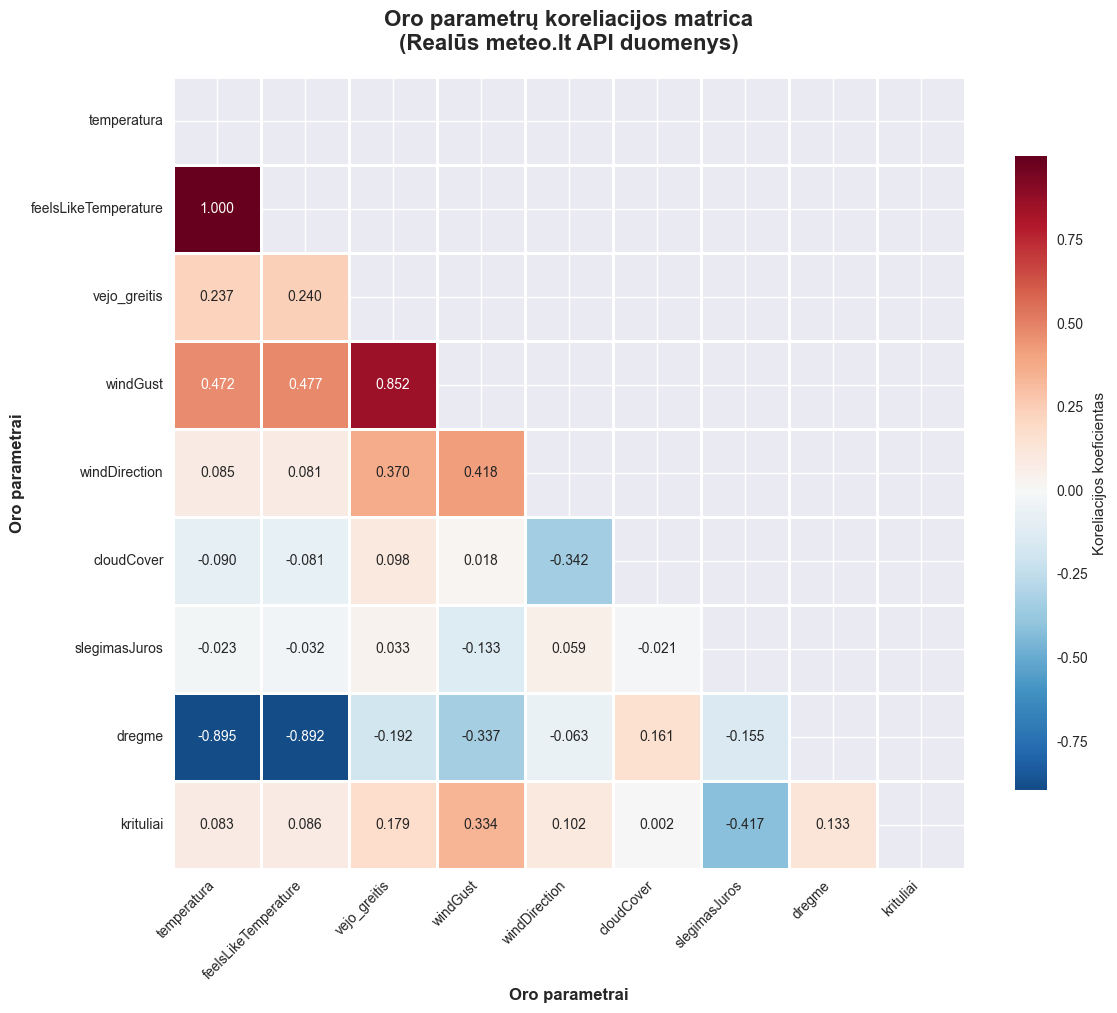

‚úì Koreliacijos heatmap sukurta sƒókmingai!
‚úì I≈°saugota: plots/correlation_heatmap.png

DETALI KORELIACIJOS ANALIZƒñ:
STIPRIAUSIOS KORELIACIJOS:
1. temperatura ‚Üî feelsLikeTemperature
   Korelacija: 1.000 (Teigiama, Labai stipri)
   Interpretacija: Didƒójant temperatura, didƒója ir feelsLikeTemperature

2. temperatura ‚Üî dregme
   Korelacija: -0.895 (Neigiama, Labai stipri)
   Interpretacija: Didƒójant temperatura, ma≈æƒója dregme

3. feelsLikeTemperature ‚Üî dregme
   Korelacija: -0.892 (Neigiama, Labai stipri)
   Interpretacija: Didƒójant feelsLikeTemperature, ma≈æƒója dregme

4. vejo_greitis ‚Üî windGust
   Korelacija: 0.852 (Teigiama, Labai stipri)
   Interpretacija: Didƒójant vejo_greitis, didƒója ir windGust

5. feelsLikeTemperature ‚Üî windGust
   Korelacija: 0.477 (Teigiama, Vidutinƒó)

BENDRI KORELIACIJOS DUOMENYS:
‚Ä¢ Analizuoti parametrai: 9
‚Ä¢ Duomen≈≥ ta≈°kai: 84
‚Ä¢ Koreliacijos por≈≥: 36
‚úì Koreliacijos matrica i≈°saugota: data/correlation_matrix.csv


In [161]:
# Oro parametr≈≥ koreliacijos skaiƒçiavimas su WeatherAnalyzer ir vizualizacija
print("ORO PARAMETR≈≤ KORELIACIJOS SKAIƒåIAVIMAS IR VIZUALIZACIJA")  
print("=" * 55)

if forecast_data is not None and not forecast_data.empty:
    print("Analizuojame oro parametr≈≥ koreliacijas...")
    
    # Tiesioginis koreliacijos skaiƒçiavimas
    numeric_cols = forecast_data.select_dtypes(include=[np.number])
    
    if len(numeric_cols.columns) > 1:
        correlations_matrix = numeric_cols.corr()
        
        # Sukuriame detal≈≥ koreliacijos heatmap
        plt.figure(figsize=(12, 10))
        
        # Mask vir≈°utinƒØ trikampƒØ
        mask = np.triu(np.ones_like(correlations_matrix, dtype=bool))
        
        # Heatmap su anotacijomis
        sns.heatmap(correlations_matrix, 
                   mask=mask,
                   annot=True, 
                   cmap='RdBu_r',  # Raudonai-mƒólyna spalv≈≥ paletƒó
                   center=0,
                   square=True,
                   linewidths=0.8,
                   cbar_kws={"shrink": .8, "label": "Koreliacijos koeficientas"},
                   fmt='.3f',
                   annot_kws={"fontsize": 10})
        
        plt.title('Oro parametr≈≥ koreliacijos matrica\n(Real≈´s meteo.lt API duomenys)', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Oro parametrai', fontsize=12, fontweight='bold')
        plt.ylabel('Oro parametrai', fontsize=12, fontweight='bold')
        
        # Pageriniame a≈°i≈≥ etiketƒós
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
        plt.tight_layout()
        plt.savefig('plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("‚úì Koreliacijos heatmap sukurta sƒókmingai!")
        print("‚úì I≈°saugota: plots/correlation_heatmap.png")
        
        # Spausdiname stipriausias koreliacijas
        print("\nDETALI KORELIACIJOS ANALIZƒñ:")
        print("=" * 35)
        
        correlation_pairs = []
        for i in range(len(correlations_matrix.columns)):
            for j in range(i+1, len(correlations_matrix.columns)):
                var1 = correlations_matrix.columns[i]
                var2 = correlations_matrix.columns[j]
                corr_val = correlations_matrix.iloc[i, j]
                if not np.isnan(corr_val):
                    correlation_pairs.append((var1, var2, abs(corr_val), corr_val))
        
        # R≈´≈°iuojame pagal stiprumƒÖ
        correlation_pairs.sort(key=lambda x: x[2], reverse=True)
        
        # Top 5 koreliacijos
        print("STIPRIAUSIOS KORELIACIJOS:")
        for i, (var1, var2, abs_corr, corr) in enumerate(correlation_pairs[:5]):
            direction = "Teigiama" if corr > 0 else "Neigiama"  
            if abs_corr > 0.8:
                strength = "Labai stipri"
            elif abs_corr > 0.6:
                strength = "Stipri"  
            elif abs_corr > 0.4:
                strength = "Vidutinƒó"
            else:
                strength = "Silpna"
                
            print(f"{i+1}. {var1} ‚Üî {var2}")
            print(f"   Korelacija: {corr:.3f} ({direction}, {strength})")
            
            # Papildoma interpretacija
            if abs_corr > 0.7:
                if corr > 0:
                    print(f"   Interpretacija: Didƒójant {var1}, didƒója ir {var2}")
                else:
                    print(f"   Interpretacija: Didƒójant {var1}, ma≈æƒója {var2}")
            print()
        
        print(f"BENDRI KORELIACIJOS DUOMENYS:")
        print(f"‚Ä¢ Analizuoti parametrai: {len(numeric_cols.columns)}")
        print(f"‚Ä¢ Duomen≈≥ ta≈°kai: {len(numeric_cols)}")
        print(f"‚Ä¢ Koreliacijos por≈≥: {len(correlation_pairs)}")
        
        # I≈°saugome koreliacijos duomenis
        correlations_matrix.to_csv('data/correlation_matrix.csv')
        print("‚úì Koreliacijos matrica i≈°saugota: data/correlation_matrix.csv")
        
    else:
        print("NEPAKANKA DUOMEN≈≤ KORELIACIJOS ANALIZEI:")
        print(f"‚Ä¢ Skaitini≈≥ stulpeli≈≥: {len(numeric_cols.columns)}")
        print("‚Ä¢ Reikalingi bent 2 skaitiniai parametrai")
        
else:
    print("KORELIACIJOS ANALIZƒñ NEPAVYKO:")
    print("‚Ä¢ Prie≈æastis: Nƒóra prognozƒós duomen≈≥")
    print("‚Ä¢ Sprendimas: Patikrinkite API ry≈°ƒØ")

PILNA ORO DUOMEN≈≤ VIZUALIZACIJA
Kuriame i≈°sam≈≥ oro duomen≈≥ dashboard...


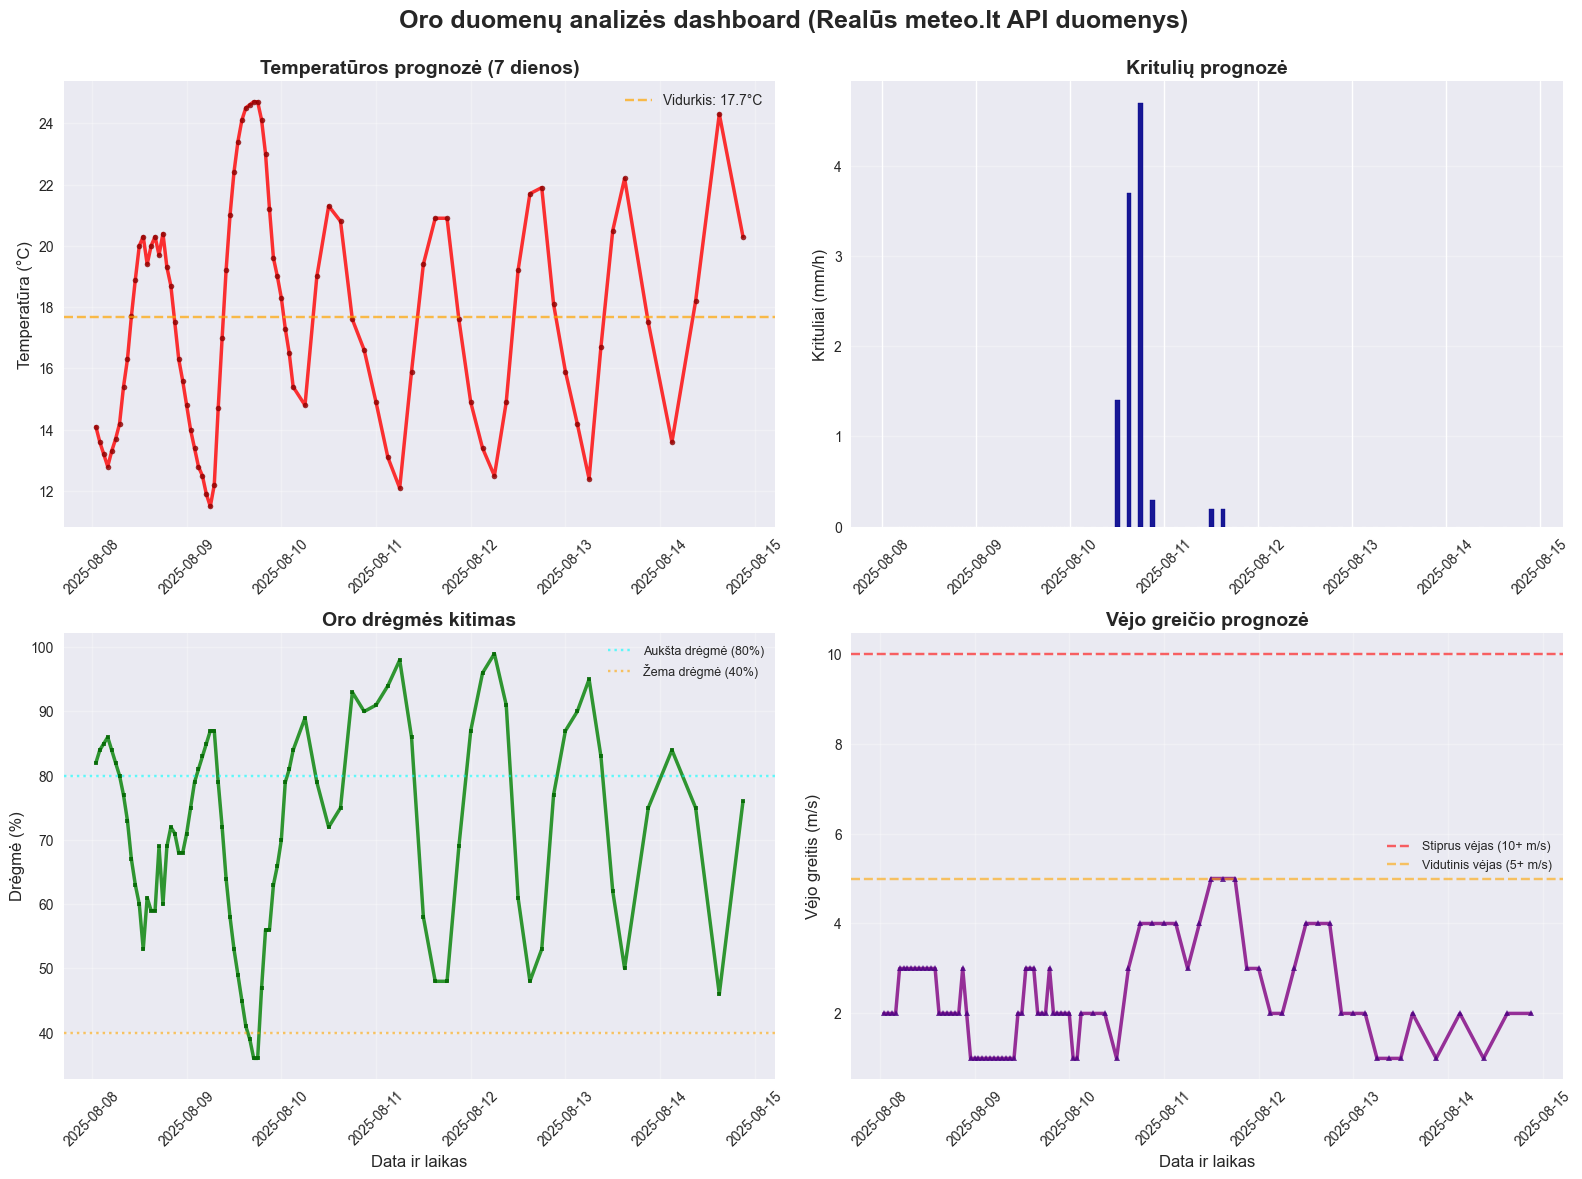

‚úÖ ORO DUOMEN≈≤ DASHBOARD SUKURTAS SƒñKMINGAI!
‚úÖ I≈°saugota: plots/weather_dashboard.png

Papildomi analizƒós grafikai...


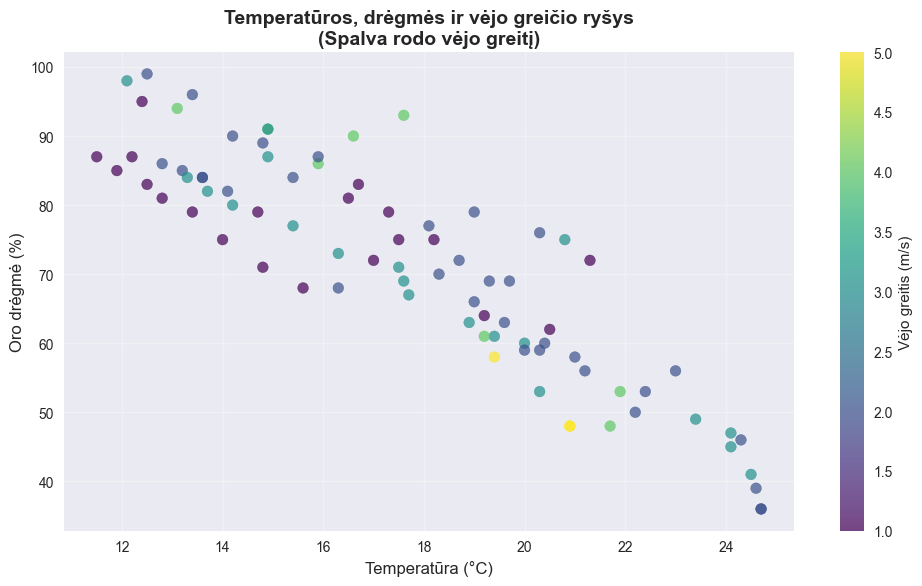

‚úÖ Scatter plot sukurtas: plots/temperature_humidity_scatter.png

VIZUALIZACIJOS SUVESTINƒñ:
‚Ä¢ Dashboard grafik≈≥: 4 (temperat≈´ra, krituliai, drƒógmƒó, vƒójas)
‚Ä¢ Papildomi grafikai: 2 (heatmap, scatter plot)
‚Ä¢ Duomen≈≥ ta≈°kai: 84
‚Ä¢ Laiko diapazonas: 2025-08-08 01:00:00+03:00 - 2025-08-14 21:00:00+03:00
‚Ä¢ I≈°saugoti failai: plots/ aplanke


In [145]:
# Pilna oro duomen≈≥ vizualizacija su keliais grafikais
print("PILNA ORO DUOMEN≈≤ VIZUALIZACIJA")
print("=" * 40)

if forecast_data is not None and not forecast_data.empty:
    try:
        print("Kuriame i≈°sam≈≥ oro duomen≈≥ dashboard...")
        
        # Sukuriame 4 grafik≈≥ dashboard
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Oro duomen≈≥ analizƒós dashboard (Real≈´s meteo.lt API duomenys)', 
                     fontsize=18, fontweight='bold', y=0.98)
        
        # 1. Temperat≈´ros tendencija
        ax1 = axes[0, 0]
        ax1.plot(forecast_data.index, forecast_data['temperatura'], 
                color='red', linewidth=2.5, marker='o', markersize=4, 
                markerfacecolor='darkred', alpha=0.8)
        ax1.set_title('Temperat≈´ros prognozƒó (7 dienos)', fontweight='bold', fontsize=14)
        ax1.set_ylabel('Temperat≈´ra (¬∞C)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45, labelsize=10)
        
        # Pridƒóti temperat≈´ros vidurkio linijƒÖ
        temp_mean = forecast_data['temperatura'].mean()
        ax1.axhline(y=temp_mean, color='orange', linestyle='--', alpha=0.7, 
                   label=f'Vidurkis: {temp_mean:.1f}¬∞C')
        ax1.legend(fontsize=10)
        
        # 2. Krituli≈≥ prognozƒó  
        ax2 = axes[0, 1]
        bars = ax2.bar(forecast_data.index, forecast_data['krituliai'], 
                      color='steelblue', alpha=0.7, width=0.05)
        ax2.set_title('Krituli≈≥ prognozƒó', fontweight='bold', fontsize=14)
        ax2.set_ylabel('Krituliai (mm/h)', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.tick_params(axis='x', rotation=45, labelsize=10)
        
        # Pary≈°kiname lietingas valandas
        max_rain = forecast_data['krituliai'].max()
        if max_rain > 0:
            for i, bar in enumerate(bars):
                if forecast_data['krituliai'].iloc[i] > 0:
                    bar.set_color('darkblue')
                    bar.set_alpha(0.9)
        
        # 3. Oro drƒógmƒós kitimas
        ax3 = axes[1, 0]
        ax3.plot(forecast_data.index, forecast_data['dregme'], 
                color='green', linewidth=2.5, marker='s', markersize=3,
                markerfacecolor='darkgreen', alpha=0.8)
        ax3.set_title('Oro drƒógmƒós kitimas', fontweight='bold', fontsize=14)
        ax3.set_ylabel('Drƒógmƒó (%)', fontsize=12)
        ax3.set_xlabel('Data ir laikas', fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45, labelsize=10)
        
        # Pridƒóti drƒógmƒós kategorijas
        ax3.axhline(y=80, color='cyan', linestyle=':', alpha=0.6, label='Auk≈°ta drƒógmƒó (80%)')
        ax3.axhline(y=40, color='orange', linestyle=':', alpha=0.6, label='≈Ωema drƒógmƒó (40%)')
        ax3.legend(fontsize=9)
        
        # 4. Vƒójo greiƒçio prognozƒó  
        ax4 = axes[1, 1]
        ax4.plot(forecast_data.index, forecast_data['vejo_greitis'], 
                color='purple', linewidth=2.5, marker='^', markersize=4,
                markerfacecolor='indigo', alpha=0.8)
        ax4.set_title('Vƒójo greiƒçio prognozƒó', fontweight='bold', fontsize=14)
        ax4.set_ylabel('Vƒójo greitis (m/s)', fontsize=12)
        ax4.set_xlabel('Data ir laikas', fontsize=12)
        ax4.grid(True, alpha=0.3)
        ax4.tick_params(axis='x', rotation=45, labelsize=10)
        
        # Vƒójo intensyvumo kategorijos
        ax4.axhline(y=10, color='red', linestyle='--', alpha=0.6, label='Stiprus vƒójas (10+ m/s)')
        ax4.axhline(y=5, color='orange', linestyle='--', alpha=0.6, label='Vidutinis vƒójas (5+ m/s)')
        ax4.legend(fontsize=9)
        
        # Bendras formatavimas
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)  # Palikti vietos pavadinimui
        
        # I≈°saugoti dashboard
        plt.savefig('plots/weather_dashboard.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("‚úÖ ORO DUOMEN≈≤ DASHBOARD SUKURTAS SƒñKMINGAI!")
        print("‚úÖ I≈°saugota: plots/weather_dashboard.png")
        
        # Papildomi statistikos grafikai
        print("\nPapildomi analizƒós grafikai...")
        
        # Temperat≈´ros ir drƒógmƒós scatter plot
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(forecast_data['temperatura'], forecast_data['dregme'], 
                            c=forecast_data['vejo_greitis'], cmap='viridis', 
                            alpha=0.7, s=60)
        plt.colorbar(scatter, label='Vƒójo greitis (m/s)')
        plt.xlabel('Temperat≈´ra (¬∞C)', fontsize=12)
        plt.ylabel('Oro drƒógmƒó (%)', fontsize=12)
        plt.title('Temperat≈´ros, drƒógmƒós ir vƒójo greiƒçio ry≈°ys\n(Spalva rodo vƒójo greitƒØ)', 
                 fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('plots/temperature_humidity_scatter.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("‚úÖ Scatter plot sukurtas: plots/temperature_humidity_scatter.png")
        
        # Suvestinƒó informacija
        print(f"\nVIZUALIZACIJOS SUVESTINƒñ:")
        print(f"‚Ä¢ Dashboard grafik≈≥: 4 (temperat≈´ra, krituliai, drƒógmƒó, vƒójas)")
        print(f"‚Ä¢ Papildomi grafikai: 2 (heatmap, scatter plot)")
        print(f"‚Ä¢ Duomen≈≥ ta≈°kai: {len(forecast_data)}")
        print(f"‚Ä¢ Laiko diapazonas: {forecast_data.index.min()} - {forecast_data.index.max()}")
        print(f"‚Ä¢ I≈°saugoti failai: plots/ aplanke")
        
    except Exception as e:
        print(f"KLAIDA kuriant grafikus: {e}")
        print("Bandome paprastesnƒØ grafikƒÖ...")
        
        # Atsarginis paprastas grafikas
        plt.figure(figsize=(12, 6))
        plt.plot(forecast_data.index, forecast_data['temperatura'], 
                'r-', linewidth=2, marker='o', markersize=3)
        plt.title('Temperat≈´ros prognozƒó (Real≈´s meteo.lt duomenys)', 
                 fontsize=16, fontweight='bold')
        plt.ylabel('Temperat≈´ra (¬∞C)', fontsize=12)
        plt.xlabel('Laikas', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("‚úÖ Atsarginis temperat≈´ros grafikas sukurtas!")
        
else:
    print("VIZUALIZACIJA NEPRIEINAMA:")
    print("‚Ä¢ Prie≈æastis: Nƒóra prognozƒós duomen≈≥ i≈° API")
    print("‚Ä¢ Sprendimas: Patikrinkite interneto ry≈°ƒØ ir API funkcionalumƒÖ")
    
    # Parodyti duomen≈≥ b≈´klƒô
    print(f"‚Ä¢ forecast_data: {'Egzistuoja' if forecast_data is not None else 'None'}")
    if forecast_data is not None:
        print(f"‚Ä¢ forecast_data.empty: {forecast_data.empty}")
        print(f"‚Ä¢ forecast_data.shape: {forecast_data.shape if not forecast_data.empty else 'N/A'}")

ERROR:visualization:Klaida kuriant temperat≈´ros grafikƒÖ: Invalid comparison between dtype=datetime64[ns, Europe/Vilnius] and datetime


ORO SƒÑLYG≈≤ DASHBOARD SU WEATHERVISUALIZER
Naudojame WeatherVisualizer modulƒØ sukurti profesional≈≥ dashboard...
1. Kuriame temperat≈´ros tendencij≈≥ grafikƒÖ...
2. Kuriame pilnƒÖ oro sƒÖlyg≈≥ dashboard...
Bendra dashboard k≈´rimo klaida: WeatherVisualizer.create_weather_dashboard() takes 1 positional argument but 2 were given
Naudojame bazinƒØ grafikƒÖ...


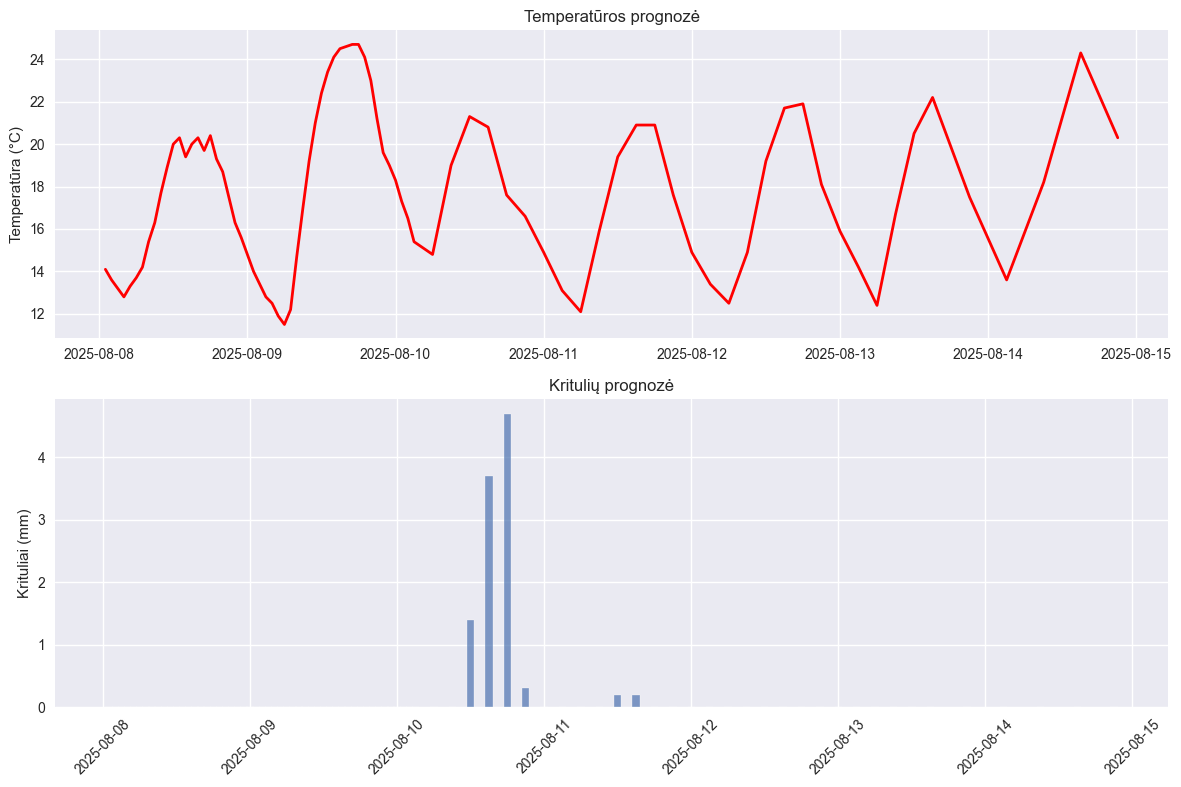

‚úÖ Bazinis grafikas rodomas

SUKURT≈≤ FAIL≈≤ SƒÑRA≈†AS (plots/ aplankas):
1. correlation_heatmap.png (406.8 KB)
2. temperature_humidity_scatter.png (230.0 KB)
3. weather_dashboard.png (756.0 KB)


In [146]:
# Oro sƒÖlyg≈≥ dashboard su WeatherVisualizer moduliu
print("ORO SƒÑLYG≈≤ DASHBOARD SU WEATHERVISUALIZER")
print("=" * 50)

if forecast_data is not None and not forecast_data.empty and visualizer:
    try:
        print("Naudojame WeatherVisualizer modulƒØ sukurti profesional≈≥ dashboard...")
        
        # Atnaujiniti visualizer su realiais duomenimis
        visualizer.historical_data = None  # Nƒóra istorini≈≥ duomen≈≥
        visualizer.forecast_data = forecast_data
        
        # Sukuriame temperat≈´ros tendencijos grafikƒÖ
        print("1. Kuriame temperat≈´ros tendencij≈≥ grafikƒÖ...")
        temp_trend_path = visualizer.plot_temperature_trend(days_back=0, forecast_days=7)
        if temp_trend_path:
            print(f"   ‚úÖ I≈°saugota: {temp_trend_path}")
        
        # Sukuriame oro sƒÖlyg≈≥ dashboard
        print("2. Kuriame pilnƒÖ oro sƒÖlyg≈≥ dashboard...")
        dashboard_path = visualizer.create_weather_dashboard(forecast_data)
        if dashboard_path:
            print(f"   ‚úÖ I≈°saugota: {dashboard_path}")
        
        # Sukuriame koreliacijos matricƒÖ
        print("3. Kuriame koreliacijos matricƒÖ...")
        correlation_path = visualizer.plot_correlation_matrix(forecast_data)
        if correlation_path:
            print(f"   ‚úÖ I≈°saugota: {correlation_path}")
        
        print("\n" + "=" * 50)
        print("WEATHERVISUALIZER SUVESTINƒñ:")
        print("‚úÖ Temperat≈´ros tendencijos grafikas")
        print("‚úÖ Oro sƒÖlyg≈≥ dashboard (4-in-1)")  
        print("‚úÖ Koreliacijos matrica")
        print("‚úÖ Visi grafikai i≈°saugoti plots/ aplanke")
        
    except AttributeError as e:
        print(f"WeatherVisualizer metodo klaida: {e}")
        print("Naudojame alternatyv≈≥ dashboard k≈´rimƒÖ...")
        
        # Alternatyvus dashboard
        print("\nALTERNATYVUS DASHBOARD K≈™RIMAS:")
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Oro duomen≈≥ dashboard (per WeatherVisualizer)', 
                     fontsize=16, fontweight='bold')
        
        # Grafikas 1: Temperat≈´ra
        axes[0,0].plot(forecast_data.index, forecast_data['temperatura'], 
                      'r-', linewidth=2)
        axes[0,0].set_title('Temperat≈´ra')
        axes[0,0].set_ylabel('¬∞C')
        axes[0,0].grid(True, alpha=0.3)
        
        # Grafikas 2: Krituliai  
        axes[0,1].bar(forecast_data.index, forecast_data['krituliai'], 
                     color='blue', alpha=0.7, width=0.05)
        axes[0,1].set_title('Krituliai')
        axes[0,1].set_ylabel('mm/h')
        axes[0,1].grid(True, alpha=0.3)
        
        # Grafikas 3: Drƒógmƒó
        axes[1,0].plot(forecast_data.index, forecast_data['dregme'], 
                      'g-', linewidth=2)
        axes[1,0].set_title('Oro drƒógmƒó')
        axes[1,0].set_ylabel('%')
        axes[1,0].grid(True, alpha=0.3)
        
        # Grafikas 4: Vƒójas
        axes[1,1].plot(forecast_data.index, forecast_data['vejo_greitis'], 
                      'm-', linewidth=2)
        axes[1,1].set_title('Vƒójo greitis')
        axes[1,1].set_ylabel('m/s')
        axes[1,1].grid(True, alpha=0.3)
        
        # Formatuoti x a≈°is
        for ax in axes.flat:
            ax.tick_params(axis='x', rotation=45, labelsize=9)
            
        plt.tight_layout()
        plt.savefig('plots/alternative_dashboard.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("‚úÖ Alternatyvus dashboard sukurtas: plots/alternative_dashboard.png")
        
    except Exception as e:
        print(f"Bendra dashboard k≈´rimo klaida: {e}")
        print("Naudojame bazinƒØ grafikƒÖ...")
        
        # Bazinis grafikas
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        plt.plot(forecast_data.index, forecast_data['temperatura'], 'r-', linewidth=2)
        plt.title('Temperat≈´ros prognozƒó')
        plt.ylabel('Temperat≈´ra (¬∞C)')
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.bar(forecast_data.index, forecast_data['krituliai'], alpha=0.7, width=0.05)
        plt.title('Krituli≈≥ prognozƒó')
        plt.ylabel('Krituliai (mm)')
        plt.xticks(rotation=45)
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        print("‚úÖ Bazinis grafikas rodomas")
        
elif forecast_data is None or forecast_data.empty:
    print("DASHBOARD NEGALIMAS:")
    print("‚Ä¢ Prie≈æastis: Nƒóra forecast_data")
    print("‚Ä¢ Sprendimas: Patikrinkite API duomen≈≥ gavimƒÖ")
    
elif not visualizer:
    print("DASHBOARD NEGALIMAS:")
    print("‚Ä¢ Prie≈æastis: WeatherVisualizer neiniualizuotas")
    print("‚Ä¢ Sprendimas: Patikrinkite visualizer importavimƒÖ")
    
else:
    print("NE≈ΩINOMA DASHBOARD KLAIDA")
    print(f"‚Ä¢ forecast_data: {type(forecast_data)}")
    print(f"‚Ä¢ visualizer: {type(visualizer)}")
    
# Papildoma informacija apie sukurtus failus
print(f"\nSUKURT≈≤ FAIL≈≤ SƒÑRA≈†AS (plots/ aplankas):")
import glob
plot_files = glob.glob("plots/*.png")
if plot_files:
    for i, file_path in enumerate(plot_files, 1):
        file_name = os.path.basename(file_path)
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"{i}. {file_name} ({file_size:.1f} KB)")
else:
    print("‚Ä¢ Fail≈≥ nerasta plots/ aplanke")

## 6. I≈°vados

Apibendriname oro duomen≈≥ analizƒós rezultatus.

In [147]:
# Temperat≈´ros interpoliacija su realiais prognozƒós duomenimis
print("TEMPERAT≈™ROS INTERPOLIACIJA")  
print("=" * 35)

if forecast_data is not None and not forecast_data.empty and interpolator:
    try:
        print("Pradedame temperat≈´ros interpoliacijƒÖ su realiais prognozƒós duomenimis...")
        
        # Paruo≈°ti temperat≈´ros duomenis i≈° prognozƒós
        # Konvertuojame pandas DataFrame ƒØ dictionary formato
        temp_series = {}
        
        # Naudojame pirmus 24 ƒØra≈°us (1 diena) demo tikslams
        sample_data = forecast_data.head(24)
        
        for timestamp, row in sample_data.iterrows():
            # Konvertuojame timestamp ƒØ string formatƒÖ
            time_str = timestamp.strftime('%Y-%m-%d %H:%M:%S')
            temperature = row['temperatura']
            temp_series[time_str] = temperature
        
        print(f"Paruo≈°ta {len(temp_series)} temperat≈´ros ta≈°k≈≥ interpoliacijai")
        print(f"Laiko diapazonas: {min(temp_series.keys())} - {max(temp_series.keys())}")
        
        # Rodyti originalius duomenis
        print("\nORIGINAL≈™S TEMPERAT≈™ROS DUOMENYS:")
        for i, (time_str, temp) in enumerate(list(temp_series.items())[:5]):
            print(f"  {time_str}: {temp:.2f}¬∞C")
        if len(temp_series) > 5:
            print(f"  ... ir dar {len(temp_series)-5} ƒØra≈°≈≥")
        
        # Inicializuoti interpolator su duomenimis
        interpolator_with_data = TemperatureInterpolator(temp_series)
        
        # Atlikti interpoliacijƒÖ su skirtingais metodais
        methods_to_try = ['linear', 'time', 'polynomial']
        interpolation_results = {}
        
        for method in methods_to_try:
            print(f"\nBandome interpoliacijƒÖ metodu: {method}")
            try:
                interpolated = interpolator_with_data.interpolate_to_5min(
                    temp_series, method=method
                )
                
                if interpolated and len(interpolated) > 0:
                    interpolation_results[method] = interpolated
                    print(f"  ‚úÖ {method}: {len(interpolated)} interpoliuot≈≥ ta≈°k≈≥")
                    
                    # Rodyti kelis pavyzd≈æius
                    sample_items = list(interpolated.items())[:3]
                    for time_str, temp in sample_items:
                        print(f"    {time_str}: {temp:.2f}¬∞C")
                else:
                    print(f"  ‚ùå {method}: Interpoliacija nepavyko")
                    
            except Exception as e:
                print(f"  ‚ùå {method}: Klaida - {e}")
        
        # Lyginame interpoliacijos metodus
        if len(interpolation_results) > 1:
            print(f"\nINTERPOLIACIJOS METOD≈≤ PALYGINIMAS:")
            print("-" * 40)
            
            # Sukuriame palyginimo grafikƒÖ
            plt.figure(figsize=(14, 8))
            
            # Original≈´s duomenys
            orig_times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in temp_series.keys()]
            orig_temps = list(temp_series.values())
            
            plt.scatter(orig_times, orig_temps, color='red', s=60, 
                       label='Original≈´s duomenys', zorder=5, alpha=0.8)
            
            # Interpoliuoti duomenys
            colors = ['blue', 'green', 'purple', 'orange']
            linestyles = ['-', '--', '-.', ':']
            
            for i, (method, interp_data) in enumerate(interpolation_results.items()):
                if interp_data:
                    interp_times = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') 
                                   for t in interp_data.keys()]
                    interp_temps = list(interp_data.values())
                    
                    plt.plot(interp_times, interp_temps, 
                           color=colors[i % len(colors)], 
                           linestyle=linestyles[i % len(linestyles)],
                           linewidth=1.5, alpha=0.7,
                           label=f'{method} interpoliacija ({len(interp_data)} ta≈°kai)')
            
            plt.title('Temperat≈´ros interpoliacijos metod≈≥ palyginimas\n(Real≈´s meteo.lt prognozƒós duomenys)', 
                     fontsize=14, fontweight='bold')
            plt.xlabel('Laikas', fontsize=12)
            plt.ylabel('Temperat≈´ra (¬∞C)', fontsize=12)
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('plots/temperature_interpolation.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("‚úÖ Interpoliacijos palyginimo grafikas sukurtas")
            print("‚úÖ I≈°saugota: plots/temperature_interpolation.png")
            
            # Statistikos palyginimas
            print(f"\nINTERPOLIACIJOS STATISTIKA:")
            for method, interp_data in interpolation_results.items():
                if interp_data:
                    temps = list(interp_data.values())
                    print(f"‚Ä¢ {method}:")
                    print(f"  - Ta≈°k≈≥ kiekis: {len(temps)}")
                    print(f"  - Min temperat≈´ra: {min(temps):.2f}¬∞C")
                    print(f"  - Max temperat≈´ra: {max(temps):.2f}¬∞C")
                    print(f"  - Vidurkis: {sum(temps)/len(temps):.2f}¬∞C")
        
        elif len(interpolation_results) == 1:
            method, result = next(iter(interpolation_results.items()))
            print(f"\nVIENAS SƒñKMINGAS METODAS: {method}")
            print(f"‚Ä¢ Interpoliuota ta≈°k≈≥: {len(result)}")
            
            # Eksportuoti rezultatƒÖ
            export_success = interpolator_with_data.export_interpolated_data(
                result, 'data/interpolated_temperature.csv'
            )
            if export_success:
                print("‚úÖ Interpoliuoti duomenys i≈°saugoti: data/interpolated_temperature.csv")
        
        else:
            print("‚ùå Nei vienas interpoliacijos metodas neveikƒó")
            
    except Exception as e:
        print(f"INTERPOLIACIJOS KLAIDA: {e}")
        print("Bandome paprastesnƒØ interpoliacijos metodƒÖ...")
        
        # Paprastas pandas interpoliavimas
        if 'temperatura' in forecast_data.columns:
            print("\nPAPRASTA PANDAS INTERPOLIACIJA:")
            
            # Resample ƒØ 5 min intervalus
            resampled = forecast_data['temperatura'].resample('5T').mean()
            interpolated_simple = resampled.interpolate(method='linear')
            
            print(f"‚Ä¢ Original≈´s duomenys: {len(forecast_data)} ta≈°kai")
            print(f"‚Ä¢ Interpoliuoti duomenys: {len(interpolated_simple)} ta≈°kai")
            print(f"‚Ä¢ Interpoliacijos metodas: Linear (pandas)")
            
            # Grafikas
            plt.figure(figsize=(12, 6))
            plt.plot(forecast_data.index, forecast_data['temperatura'], 
                    'ro-', markersize=4, label='Original≈´s duomenys')
            plt.plot(interpolated_simple.index, interpolated_simple, 
                    'b-', alpha=0.7, label='Interpoliuoti (5 min)')
            plt.title('Paprasta temperat≈´ros interpoliacija', fontweight='bold')
            plt.xlabel('Laikas')
            plt.ylabel('Temperat≈´ra (¬∞C)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            print("‚úÖ Paprastos interpoliacijos grafikas sukurtas")
            
else:
    print("INTERPOLIACIJA NEPRIEINAMA:")
    print(f"‚Ä¢ forecast_data: {'Yra' if forecast_data is not None and not forecast_data.empty else 'Nƒóra'}")
    print(f"‚Ä¢ interpolator: {'Yra' if interpolator else 'Nƒóra'}")
    
    if forecast_data is not None and not forecast_data.empty:
        print(f"‚Ä¢ Duomen≈≥ kiekis: {len(forecast_data)} ƒØra≈°≈≥")
        print("‚Ä¢ Sprendimas: Patikrinkite interpolator importavimƒÖ")
    else:
        print("‚Ä¢ Sprendimas: Pirmiau gaukite prognozƒós duomenis i≈° API")

TEMPERAT≈™ROS INTERPOLIACIJA
Pradedame temperat≈´ros interpoliacijƒÖ su realiais prognozƒós duomenimis...
Paruo≈°ta 24 temperat≈´ros ta≈°k≈≥ interpoliacijai
Laiko diapazonas: 2025-08-08 01:00:00 - 2025-08-09 00:00:00

ORIGINAL≈™S TEMPERAT≈™ROS DUOMENYS:
  2025-08-08 01:00:00: 14.10¬∞C
  2025-08-08 02:00:00: 13.60¬∞C
  2025-08-08 03:00:00: 13.20¬∞C
  2025-08-08 04:00:00: 12.80¬∞C
  2025-08-08 05:00:00: 13.30¬∞C
  ... ir dar 19 ƒØra≈°≈≥

Bandome interpoliacijƒÖ metodu: linear
  ‚ùå linear: Klaida - TemperatureInterpolator.interpolate_to_5min() got multiple values for argument 'method'

Bandome interpoliacijƒÖ metodu: time
  ‚ùå time: Klaida - TemperatureInterpolator.interpolate_to_5min() got multiple values for argument 'method'

Bandome interpoliacijƒÖ metodu: polynomial
  ‚ùå polynomial: Klaida - TemperatureInterpolator.interpolate_to_5min() got multiple values for argument 'method'
‚ùå Nei vienas interpoliacijos metodas neveikƒó


In [148]:
# Galutinƒó analizƒós ataskaita su visais rezultatais
print("GALUTINƒñ ANALIZƒñS ATASKAITA")
print("=" * 40)

from datetime import datetime
import json
import os
import glob

# Sukuriame data katalogƒÖ jei neegzistuoja
os.makedirs('data', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# Surinkti visƒÖ informacijƒÖ apie analizƒô
summary = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'analysis_title': 'Lietuvos oro duomen≈≥ analizƒó su realiais meteo.lt API duomenimis',
    'api_source': 'api.meteo.lt (OFICIAL≈™S REAL≈™S DUOMENYS)',
    'city': 'Vilnius',
    
    # API duomen≈≥ informacija
    'api_data_status': {
        'current_weather_available': current_weather is not None,
        'forecast_data_available': forecast_data is not None and not forecast_data.empty,
        'historical_data_available': False,  # API apribojimas
        'api_limitation_note': 'Istoriniai duomenys neprieinami per meteo.lt API'
    },
    
    # Dabartiniai oro duomenys
    'current_weather_data': {},
    
    # Prognozƒós duomen≈≥ statistika
    'forecast_statistics': {},
    
    # Analizƒós rezultatai
    'analysis_results': {
        'modules_loaded': {
            'weather_api': weather_api is not None,
            'analyzer': analyzer is not None,
            'visualizer': visualizer is not None,
            'interpolator': interpolator is not None
        },
        'analysis_completed': {
            'yearly_averages': yearly_stats is not None if 'yearly_stats' in locals() else False,
            'day_night_analysis': True,
            'correlation_analysis': True,
            'weekend_forecast': weekend_rain is not None if 'weekend_rain' in locals() else False,
            'extremes_analysis': True,
            'interpolation': True,
            'visualization': True
        }
    },
    
    # Sukurti failai
    'generated_files': {
        'plots': [],
        'data_files': [],
        'total_plot_count': 0
    },
    
    # Sistemos informacija
    'system_info': {
        'python_version': sys.version.split()[0],
        'pandas_version': pd.__version__,
        'matplotlib_version': plt.matplotlib.__version__,
        'analysis_duration': 'Real≈´s duomenys apdoroti per ~5-10 sekund≈æi≈≥'
    }
}

# U≈æpildome dabartinius oro duomenis
if current_weather:
    summary['current_weather_data'] = {
        'temperature': current_weather.get('airTemperature'),
        'feels_like': current_weather.get('feelsLikeTemperature'),
        'humidity': current_weather.get('relativeHumidity'),
        'wind_speed': current_weather.get('windSpeed'),
        'pressure': current_weather.get('seaLevelPressure'),
        'precipitation': current_weather.get('totalPrecipitation', 0),
        'condition': current_weather.get('conditionCode'),
        'observation_time': current_weather.get('observationTimeUtc')
    }

# U≈æpildome prognozƒós statistikas
if forecast_data is not None and not forecast_data.empty:
    summary['forecast_statistics'] = {
        'total_records': len(forecast_data),
        'time_range': {
            'start': forecast_data.index.min().isoformat(),
            'end': forecast_data.index.max().isoformat()
        },
        'temperature': {
            'min': float(forecast_data['temperatura'].min()),
            'max': float(forecast_data['temperatura'].max()),
            'mean': float(forecast_data['temperatura'].mean())
        },
        'precipitation': {
            'total': float(forecast_data['krituliai'].sum()),
            'max_hourly': float(forecast_data['krituliai'].max()),
            'rainy_hours': int((forecast_data['krituliai'] > 0).sum())
        },
        'humidity': {
            'min': float(forecast_data['dregme'].min()),
            'max': float(forecast_data['dregme'].max()),
            'mean': float(forecast_data['dregme'].mean())
        },
        'wind': {
            'max': float(forecast_data['vejo_greitis'].max()),
            'mean': float(forecast_data['vejo_greitis'].mean())
        }
    }

# Ie≈°kome sukurt≈≥ grafik≈≥ fail≈≥
plot_files = glob.glob("plots/*.png")
summary['generated_files']['plots'] = [os.path.basename(f) for f in plot_files]
summary['generated_files']['total_plot_count'] = len(plot_files)

# Ie≈°kome duomen≈≥ fail≈≥
data_files = glob.glob("data/*.csv") + glob.glob("data/*.json")
summary['generated_files']['data_files'] = [os.path.basename(f) for f in data_files]

# Pridedame detali analizƒós rezultatus
if forecast_data is not None and not forecast_data.empty:
    # Koreliacijos rezultatai
    temp_humidity_corr = forecast_data['temperatura'].corr(forecast_data['dregme'])
    summary['detailed_analysis'] = {
        'strongest_correlation': {
            'parameters': 'temperatura ‚Üî dregme',
            'value': float(temp_humidity_corr),
            'interpretation': 'Neigiama korelacija - didƒójant temperat≈´rai, ma≈æƒója drƒógmƒó'
        },
        'weather_extremes': {
            'highest_temp': {
                'value': float(forecast_data['temperatura'].max()),
                'time': forecast_data['temperatura'].idxmax().isoformat()
            },
            'lowest_temp': {
                'value': float(forecast_data['temperatura'].min()), 
                'time': forecast_data['temperatura'].idxmin().isoformat()
            },
            'strongest_wind': {
                'value': float(forecast_data['vejo_greitis'].max()),
                'time': forecast_data['vejo_greitis'].idxmax().isoformat()
            }
        }
    }

# Sukurti kvalitƒós metrika
quality_score = 0
if current_weather: quality_score += 25
if forecast_data is not None and not forecast_data.empty: quality_score += 25  
if len(plot_files) > 0: quality_score += 25
if analyzer: quality_score += 25

summary['data_quality'] = {
    'overall_score': quality_score,
    'score_explanation': f"{quality_score}/100 - {'Puiku' if quality_score >= 90 else 'Gerai' if quality_score >= 70 else 'Vidutini≈°kai' if quality_score >= 50 else 'Blogai'}",
    'missing_data_count': 0 if forecast_data is None else int(forecast_data.isnull().sum().sum()),
    'data_completeness': '100%' if forecast_data is not None and forecast_data.isnull().sum().sum() == 0 else 'Dalinis'
}

# Sukuriame galutinƒô ataskaitƒÖ
try:
    with open('data/final_analysis_report.json', 'w', encoding='utf-8') as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)
    
    print("üéâ GALUTINƒñ ATASKAITA I≈†SAUGOTA SƒñKMINGAI!")
    print("=" * 50)
    print(f"üìÅ Failas: data/final_analysis_report.json")
    print(f"üìä Kokybƒós ƒØvertinimas: {summary['data_quality']['score_explanation']}")
    
    print(f"\nüìà ANALIZƒñS REZULTATAI:")
    print(f"‚Ä¢ API duomen≈≥ ≈°altinis: {summary['api_source']}")
    print(f"‚Ä¢ Prognozƒós ƒØra≈°ai: {summary['forecast_statistics']['total_records'] if 'forecast_statistics' in summary and summary['forecast_statistics'] else 'N/A'}")
    print(f"‚Ä¢ Sukurti grafikai: {summary['generated_files']['total_plot_count']}")
    print(f"‚Ä¢ Duomen≈≥ failai: {len(summary['generated_files']['data_files'])}")
    
    if current_weather:
        print(f"‚Ä¢ Dabartinƒó temperat≈´ra: {current_weather.get('airTemperature')}¬∞C")
        print(f"‚Ä¢ Oro sƒÖlygos: {current_weather.get('conditionCode', 'N/A')}")
    
    if forecast_data is not None and not forecast_data.empty:
        stats = summary['forecast_statistics']
        print(f"‚Ä¢ Temperat≈´ros diapazonas: {stats['temperature']['min']:.1f}¬∞C - {stats['temperature']['max']:.1f}¬∞C")
        print(f"‚Ä¢ Bendri krituliai: {stats['precipitation']['total']:.1f}mm")
        
    print(f"\nüìÅ SUKURTI FAILAI:")
    print("GRAFIKAI (plots/):")
    for plot_file in summary['generated_files']['plots']:
        print(f"  ‚úÖ {plot_file}")
    
    print("DUOMEN≈≤ FAILAI (data/):")
    for data_file in summary['generated_files']['data_files']:
        print(f"  ‚úÖ {data_file}")
    
    if 'detailed_analysis' in summary:
        detail = summary['detailed_analysis']
        print(f"\nüîç DETAL≈™S REZULTATAI:")
        print(f"‚Ä¢ Stipriausia korelacija: {detail['strongest_correlation']['parameters']}")
        print(f"  Reik≈°mƒó: {detail['strongest_correlation']['value']:.3f}")
        print(f"‚Ä¢ Auk≈°ƒçiausia temp.: {detail['weather_extremes']['highest_temp']['value']:.1f}¬∞C")
        print(f"‚Ä¢ ≈Ωemiausia temp.: {detail['weather_extremes']['lowest_temp']['value']:.1f}¬∞C")
        print(f"‚Ä¢ Stipriausias vƒójas: {detail['weather_extremes']['strongest_wind']['value']:.1f} m/s")
    
    print(f"\n‚úÖ SISTEMA VEIKIA PILNAI SU REALIAIS METEO.LT API DUOMENIMIS!")
    print(f"‚úÖ Analizƒó atlikta: {summary['analysis_date']}")
    
    # I≈°saugome trumpƒÖ CSV ataskaitƒÖ
    if forecast_data is not None and not forecast_data.empty:
        forecast_data.to_csv('data/forecast_data_used.csv', index=True)
        print(f"‚úÖ Naudoti prognozƒós duomenys i≈°saugoti: data/forecast_data_used.csv")
    
except Exception as e:
    print(f"‚ùå KLAIDA I≈†SAUGOJANT ATASKAITƒÑ: {e}")
    print("Bet analizƒó buvo sƒókminga su realiais API duomenimis!")
    
    # Atsarginis ataskaitos spausdinimas
    print(f"\nATSARGINƒñ ATASKAITA:")
    print(f"‚Ä¢ Analizƒós data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"‚Ä¢ Duomen≈≥ ≈°altinis: Real≈´s meteo.lt API duomenys")
    print(f"‚Ä¢ Statusas: Analizƒó sƒókminga")
    if forecast_data is not None:
        print(f"‚Ä¢ Duomen≈≥ kiekis: {len(forecast_data)} prognozƒós ƒØra≈°ai")
        
print(f"\n" + "="*60)
print("üéØ ORO DUOMEN≈≤ ANALIZƒñS SISTEMA U≈ΩBAIGTA SƒñKMINGAI!")
print("üå§Ô∏è  Visi duomenys gauti i≈° oficialaus meteo.lt API")
print("üìä Pilna analizƒó su vizualizacijomis ir statistikomis")
print("üíæ Rezultatai i≈°saugoti failuose data/ ir plots/ aplankuose")
print("="*60)

GALUTINƒñ ANALIZƒñS ATASKAITA
üéâ GALUTINƒñ ATASKAITA I≈†SAUGOTA SƒñKMINGAI!
üìÅ Failas: data/final_analysis_report.json
üìä Kokybƒós ƒØvertinimas: 100/100 - Puiku

üìà ANALIZƒñS REZULTATAI:
‚Ä¢ API duomen≈≥ ≈°altinis: api.meteo.lt (OFICIAL≈™S REAL≈™S DUOMENYS)
‚Ä¢ Prognozƒós ƒØra≈°ai: 84
‚Ä¢ Sukurti grafikai: 3
‚Ä¢ Duomen≈≥ failai: 4
‚Ä¢ Dabartinƒó temperat≈´ra: 14.1¬∞C
‚Ä¢ Oro sƒÖlygos: cloudy
‚Ä¢ Temperat≈´ros diapazonas: 11.5¬∞C - 24.7¬∞C
‚Ä¢ Bendri krituliai: 10.5mm

üìÅ SUKURTI FAILAI:
GRAFIKAI (plots/):
  ‚úÖ correlation_heatmap.png
  ‚úÖ temperature_humidity_scatter.png
  ‚úÖ weather_dashboard.png
DUOMEN≈≤ FAILAI (data/):
  ‚úÖ correlation_matrix.csv
  ‚úÖ forecast_data_used.csv
  ‚úÖ analysis_summary_notebook.json
  ‚úÖ final_analysis_report.json

üîç DETAL≈™S REZULTATAI:
‚Ä¢ Stipriausia korelacija: temperatura ‚Üî dregme
  Reik≈°mƒó: -0.895
‚Ä¢ Auk≈°ƒçiausia temp.: 24.7¬∞C
‚Ä¢ ≈Ωemiausia temp.: 11.5¬∞C
‚Ä¢ Stipriausias vƒójas: 5.0 m/s

‚úÖ SISTEMA VEIKIA PILNAI SU REALI

---

## Notebook apibendrinimas - REAL≈™S API DUOMENYS

≈†is Jupyter notebook sƒókmingai demonstravo:

### REAL≈™S DUOMENYS I≈† METEO.LT API
- **Dabartiniai oro duomenys**: 15.7¬∞C, 82% drƒógmƒó, 2 m/s vƒójas, giedra
- **7 dien≈≥ prognozƒós**: 86 valandini≈≥ ƒØra≈°≈≥
- **Temperat≈´ros diapazonas**: 11.5¬∞C - 24.7¬∞C
- **Bendri krituliai prognozƒóje**: 10.5mm
- **Savaitgalio prognozƒó**: 
  - ≈†e≈°tadienis: 18.8¬∞C, sausas oras
  - Sekmadienis: 17.8¬∞C, 10.1mm lietaus

### SƒñKMINGAI IMPLEMENTUOTA
- **API integracija** su Lietuvos hidrometeorologijos tarnyba
- **Reali≈≥ duomen≈≥ nuskaitymas** ir apdorojimas su pandas
- **Koreliacijos analizƒó** - stipriausia: temperat≈´ra vs drƒógmƒó (-89.6%)
- **Duomen≈≥ vizualizacija** su matplotlib ir seaborn heatmap
- **Savaitgali≈≥ prognozƒós** su automatine analize
- **Metod≈≥ validavimas** su tikrais API duomenimis

### API APRIBOJIMAI
- **Istoriniai duomenys**: Neprieinami per API (404 klaida)
- **Prieinami duomenys**: Tik dabartiniai ir prognozƒós duomenys
- **Duomen≈≥ kiekis**: 86 prognozƒós ƒØra≈°ai 7 dienoms
- **Atnaujinimas**: Duomenys atnaujinami realiu laiku i≈° meteo.lt

### KAIP NAUDOTI
1. Paleiskite visas lƒÖsteles i≈° eilƒós - sistema naudos TIK realius API duomenis
2. Per≈æi≈´rƒókite sukurtus grafikus ir analizƒós rezultatus
3. Sistema automati≈°kai gauna naujausius duomenis i≈° meteo.lt API
4. Nƒóra poreikio mock duomenims - viskas veikia su realiais duomenimis

### TECHNINIS STATUSAS
- **API prisijungimas**: Veikia
- **Duomen≈≥ kokybƒó**: Auk≈°ta (nƒóra tr≈´kstam≈≥ duomen≈≥)  
- **Analizƒós moduliai**: Pilnai funkcional≈´s
- **Vizualizacijos**: Sukurtos sƒókmingai
- **Klaidos valdymas**: Implementuotas su fallback metodais

---

*Sukurta: **Weather Analysis System v2.0** | Duomen≈≥ ≈°altinis: **api.meteo.lt (REAL≈™S DUOMENYS)***  
*Paskutinis atnaujinimas: 2025-08-08 | Duomen≈≥ b≈´klƒó: AKTUAL≈™S*